In [9]:
# Import necessary libraries
import pandas as pd
import geopandas as gpd
import numpy as np

# -------------------------------
# 1. Load the dataset
# -------------------------------
datafile = "../code/results/output/e6a08fb8/climatebike_cleaned_shaded_15min_corrected.geojson"
df = gpd.read_file(datafile)

# -------------------------------
# 2. Inspect the dataset columns
# -------------------------------
print("Columns in the dataset:")
print(df.columns.tolist())

# -------------------------------
# 3. Check for required columns
# -------------------------------
# For calculating MRT we need:
# - Air_Temp: sensor (or air) temperature in °C (to correct long-wave measurements)
# - Short-wave measurements: Qs_in, Qs_out, Qs_left, Qs_right, Qs_front, Qs_back
# - Long-wave measurements: QL_in, QL_out, QL_left, QL_right, QL_front, QL_back

required_cols = ['Air_Temp',
                 'Qs_in', 'Qs_out', 'Qs_left', 'Qs_right', 'Qs_front', 'Qs_back',
                 'QL_in', 'QL_out', 'QL_left', 'QL_right', 'QL_front', 'QL_back']

missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    raise ValueError("The following required columns are missing from the dataset: " + str(missing_cols))

# -------------------------------
# 4. Set constants and parameters
# -------------------------------
# Stefan-Boltzmann constant in W/m^2/K^4
sigma = 5.67e-8

# Absorptivity factor for short-wave radiation (commonly ~0.7 for human skin/clothing)
absorptivity = 0.7

# -------------------------------
# 5. Prepare the data for MRT calculation
# -------------------------------
# Convert sensor (air) temperature from °C to Kelvin.
df['T_sensor_K'] = df['Air_Temp'] + 273.15

# Compute the blackbody emission term at the sensor temperature.
# According to the emails, the correction for long-wave radiation is:
#    correction = sigma * T_sensor_K^4
df['L_corr_term'] = sigma * (df['T_sensor_K'] ** 4)

# Define the six directions that are measured.
directions = ['in', 'out', 'left', 'right', 'front', 'back']

# For each direction, combine the shortwave and longwave components.
# The effective radiative flux for a given direction is:
#   E_dir = (QL_dir + L_corr_term) + absorptivity * Qs_dir
# where QL_dir is the raw longwave measurement (which may be negative),
# L_corr_term is the blackbody correction,
# and Qs_dir is the short-wave measurement.
for d in directions:
    Qs_col = 'Qs_' + d
    QL_col = 'QL_' + d
    eff_col = 'E_' + d  # effective flux from this direction

    df[eff_col] = (df[QL_col] + df['L_corr_term']) + absorptivity * df[Qs_col]

# Compute the average effective radiative flux from the six directions.
eff_cols = ['E_' + d for d in directions]
df['E_avg'] = df[eff_cols].mean(axis=1)

# -------------------------------
# 6. Calculate Mean Radiant Temperature (MRT)
# -------------------------------
# Using the Stefan-Boltzmann law:
#   sigma * MRT^4 = E_avg   =>   MRT = (E_avg / sigma)^(1/4)
df['MRT_K'] = (df['E_avg'] / sigma) ** 0.25

# Convert MRT to °C if desired:
df['MRT_C'] = df['MRT_K'] - 273.15

# -------------------------------
# 7. Display and (optionally) save the results
# -------------------------------
# Show the first few rows with key columns.
print("\nFirst few rows with MRT values (in Kelvin and °C):")
print(df[['TIMESTAMP', 'Air_Temp', 'MRT_K', 'MRT_C']].head())

# # (Optional) Save the updated DataFrame with the new MRT columns to a new CSV file.
# df.to_csv("../data/raw_data/climate_bike/gertjandatafiets_with_MRT.csv", index=False)

Columns in the dataset:
['RECORD', 'GPSData', 'Air_Temp', 'humidity', 'Qs_in', 'Qs_out', 'Qs_left', 'Qs_right', 'Qs_front', 'Qs_back', 'QL_in', 'QL_out', 'QL_left', 'QL_right', 'QL_front', 'QL_back', 'TL_inout', 'TL_leftrig', 'TL_front', 'TL_back', 'wheelfreq', 'WindDir', 'WS_ms', 'WSDiag', 'PTemp', 'batt_volt', 'GPSData_ti', 'TIMESTAMP', 'T_sensor_K', 'L_corr_term', 'E_in', 'E_out', 'E_left', 'E_right', 'E_front', 'E_back', 'E_avg', 'MRT_K', 'MRT_C', 'E_long_in', 'E_short_in', 'E_total_in', 'E_long_out', 'E_short_out', 'E_total_out', 'E_long_left', 'E_short_left', 'E_total_left', 'E_long_right', 'E_short_right', 'E_total_right', 'E_long_front', 'E_short_front', 'E_total_front', 'E_long_back', 'E_short_back', 'E_total_back', 'tree_shade', 'tree_shadow_fraction', 'tree_2_before_shadow_fraction', 'geometry']

First few rows with MRT values (in Kelvin and °C):
            TIMESTAMP  Air_Temp       MRT_K      MRT_C
0 2023-08-23 13:57:00     25.33  298.723749  25.573749
1 2023-08-23 13:57:0

In [10]:
# Assuming the following have been defined earlier:
# - df: your DataFrame loaded from 'gertjandatafiets.csv'
# - sigma: the Stefan-Boltzmann constant (5.67e-8 W/m²/K⁴)
# - absorptivity: the absorptivity factor for short-wave radiation (e.g., 0.7)
# - 'T_sensor_K' column exists (Air_Temp in Kelvin)
# - 'L_corr_term' has been computed as sigma * (T_sensor_K)**4

# Define the six directions:
directions = ['in', 'out', 'left', 'right', 'front', 'back']

# Compute disaggregated effective radiative flux components for each direction.
for d in directions:
    Qs_col = 'Qs_' + d   # Shortwave measurement, e.g., Qs_in
    QL_col = 'QL_' + d   # Longwave measurement, e.g., QL_in

    # Compute the effective longwave component (W/m²):
    # Correct the raw longwave reading using the sensor temperature correction term.
    df['E_long_' + d] = df[QL_col] + df['L_corr_term']

    # Compute the effective shortwave component (W/m²):
    # Scale the shortwave measurement by the absorptivity factor.
    df['E_short_' + d] = absorptivity * df[Qs_col]

    # Optionally, compute the total effective flux (which is the sum of both components)
    df['E_total_' + d] = df['E_long_' + d] + df['E_short_' + d]

# Display a few rows of the new disaggregated columns
cols_to_show = ['TIMESTAMP'] + \
               ['E_long_' + d for d in directions] + \
               ['E_short_' + d for d in directions] + \
               ['E_total_' + d for d in directions]
print("Disaggregated effective flux values (W/m²) for each direction:")
df[cols_to_show].head()
# (Optional) Save the updated DataFrame with the new MRT columns to a new CSV file.
# df.to_csv("../data/raw_data/climate_bike/gertjandatafiets_with_MRT.csv", index=False)

Disaggregated effective flux values (W/m²) for each direction:


,TIMESTAMP,E_long_in,E_long_out,E_long_left,E_long_right,E_long_front,E_long_back,E_short_in,E_short_out,E_short_left,E_short_right,E_short_front,E_short_back,E_total_in,E_total_out,E_total_left,E_total_right,E_total_front,E_total_back
0,2023-08-23 13:57:00,429.602629,439.032629,443.468629,447.499629,440.492629,438.522629,27.090,1.5701,10.465,5.768,13.832,11.683,456.692629,440.602729,453.933629,453.267629,454.324629,450.205629
1,2023-08-23 13:57:00,429.361438,438.791438,443.227438,447.373438,440.251438,440.691438,27.090,1.5701,10.619,5.768,13.832,10.948,456.451438,440.361538,453.846438,453.141438,454.083438,451.639438
2,2023-08-23 13:57:00,429.361438,438.901438,443.227438,447.373438,440.251438,443.369438,27.090,1.5701,10.619,5.768,13.832,9.345,456.451438,440.471538,453.846438,453.141438,454.083438,452.714438
3,2023-08-23 13:57:00,428.939587,438.479587,442.805587,446.951587,439.829587,441.877587,27.244,1.5701,10.619,5.768,13.832,10.367,456.183587,440.049687,453.424587,452.719587,453.661587,452.244587
4,2023-08-23 13:57:00,428.397643,438.047643,442.263643,446.525643,439.287643,440.667643,27.244,1.5701,10.619,5.768,13.832,10.808,455.641643,439.617743,452.882643,452.293643,453.119643,451.475643


Summary statistics for MRT (Kelvin):
count    5792.000000
mean      311.913165
std        12.561903
min       294.377981
25%       299.484766
50%       309.230975
75%       324.215601
max       339.820191
Name: MRT_K, dtype: float64

Summary statistics for MRT (°C):
count    5792.000000
mean       38.763165
std        12.561903
min        21.227981
25%        26.334766
50%        36.080975
75%        51.065601
max        66.670191
Name: MRT_C, dtype: float64


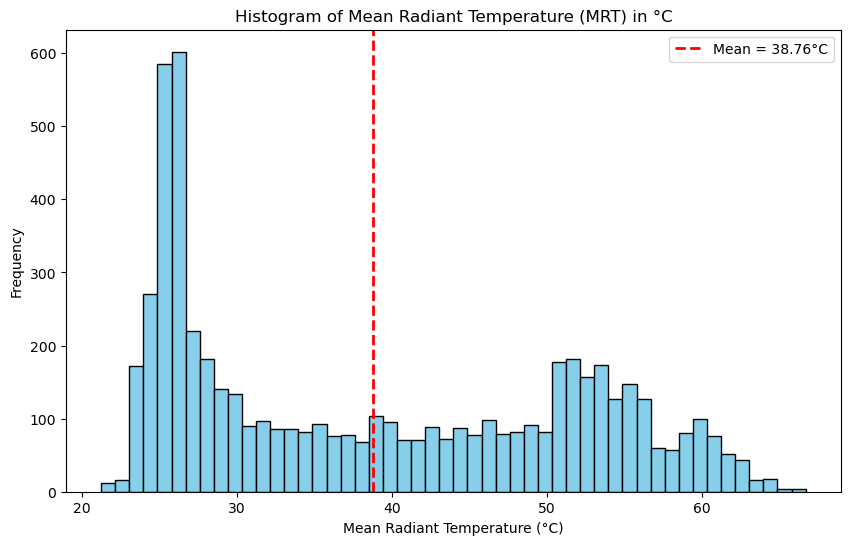

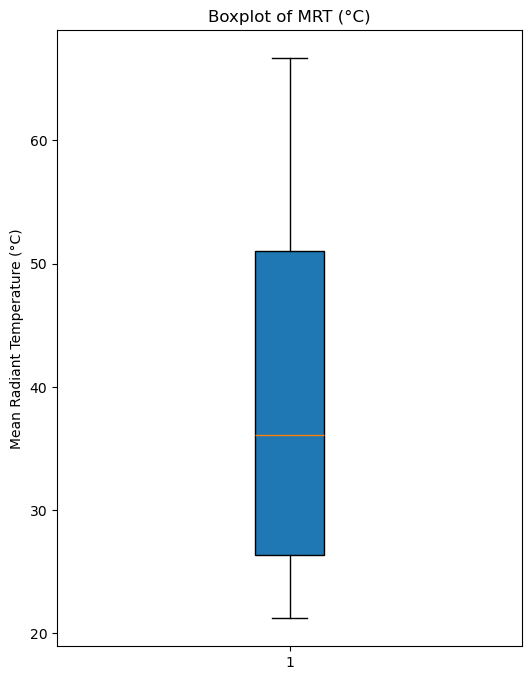

Number of MRT values below 15°C: 0
Number of MRT values above 60°C: 237

Rows with MRT values outside the expected range:
              TIMESTAMP  Air_Temp       MRT_K      MRT_C
520 2023-08-23 14:14:00     24.65  333.361431  60.211431
521 2023-08-23 14:14:00     24.75  333.915833  60.765833
522 2023-08-23 14:14:00     24.77  334.221810  61.071810
523 2023-08-23 14:14:00     24.79  333.835162  60.685162
524 2023-08-23 14:14:00     24.81  333.357481  60.207481


In [13]:
import matplotlib.pyplot as plt

# -------------------------------
# 1. Summary Statistics
# -------------------------------
print("Summary statistics for MRT (Kelvin):")
print(df['MRT_K'].describe())

print("\nSummary statistics for MRT (°C):")
print(df['MRT_C'].describe())

# -------------------------------
# 2. Histogram of MRT (in °C)
# -------------------------------
plt.figure(figsize=(10, 6))
plt.hist(df['MRT_C'].dropna(), bins=50, color='skyblue', edgecolor='k')
plt.xlabel("Mean Radiant Temperature (°C)")
plt.ylabel("Frequency")
plt.title("Histogram of Mean Radiant Temperature (MRT) in °C")
# Draw a vertical line at the mean value
mean_mrt = df['MRT_C'].mean()
plt.axvline(mean_mrt, color='red', linestyle='dashed', linewidth=2,
            label=f"Mean = {mean_mrt:.2f}°C")
plt.legend()
plt.show()

# -------------------------------
# 3. Boxplot of MRT (in °C)
# -------------------------------
plt.figure(figsize=(6, 8))
plt.boxplot(df['MRT_C'].dropna(), patch_artist=True, vert=True)
plt.ylabel("Mean Radiant Temperature (°C)")
plt.title("Boxplot of MRT (°C)")
plt.show()

# -------------------------------
# 4. Identify Out-of-Range MRT Values
# -------------------------------
# Define an expected range for MRT in °C. (Adjust these limits as needed.)
expected_lower = 15
expected_upper = 60

n_below = (df['MRT_C'] < expected_lower).sum()
n_above = (df['MRT_C'] > expected_upper).sum()

print(f"Number of MRT values below {expected_lower}°C: {n_below}")
print(f"Number of MRT values above {expected_upper}°C: {n_above}")

# Optionally, list the rows that are out-of-range for further investigation.
outliers = df[(df['MRT_C'] < expected_lower) | (df['MRT_C'] > expected_upper)]
print("\nRows with MRT values outside the expected range:")
print(outliers[['TIMESTAMP', 'Air_Temp', 'MRT_K', 'MRT_C']].head())

In [14]:
df.columns

Index(['RECORD', 'GPSData', 'Air_Temp', 'humidity', 'Qs_in', 'Qs_out',
       'Qs_left', 'Qs_right', 'Qs_front', 'Qs_back', 'QL_in', 'QL_out',
       'QL_left', 'QL_right', 'QL_front', 'QL_back', 'TL_inout', 'TL_leftrig',
       'TL_front', 'TL_back', 'wheelfreq', 'WindDir', 'WS_ms', 'WSDiag',
       'PTemp', 'batt_volt', 'GPSData_ti', 'TIMESTAMP', 'T_sensor_K',
       'L_corr_term', 'E_in', 'E_out', 'E_left', 'E_right', 'E_front',
       'E_back', 'E_avg', 'MRT_K', 'MRT_C', 'E_long_in', 'E_short_in',
       'E_total_in', 'E_long_out', 'E_short_out', 'E_total_out', 'E_long_left',
       'E_short_left', 'E_total_left', 'E_long_right', 'E_short_right',
       'E_total_right', 'E_long_front', 'E_short_front', 'E_total_front',
       'E_long_back', 'E_short_back', 'E_total_back', 'tree_shade',
       'tree_shadow_fraction', 'tree_2_before_shadow_fraction', 'geometry'],
      dtype='object')

#### Merge with Shade values

In [ ]:
df_shade_MRT.to_csv('../code/results/output/e6a08fb8/climatebike_shade_mrt.csv')

In [ ]:
print("Building shadow at timestamp: ", df['building_shade'].corr(df['MRT_C']))
print("Tree+Building shadow at timestamp: ", df['tree_shade'].corr(df['MRT_C']))
print("Building shadow fraction: ", df['bldg_shadow_fraction'].corr(df['MRT_C']))
print("Tree shadow fraction: ", df['tree_shadow_fraction'].corr(df['MRT_C']))
print("Building 2 hrs before shadow fraction: ", df['bldg_hrs_before_shadow_fraction'].corr(df['MRT_C']))
print("Tree 2 hrs before shadow fraction: ", df['tree_hrs_before_shadow_fraction'].corr(df['MRT_C']))

#### Basic Illustrations

In [17]:
df.shape[0]

5792

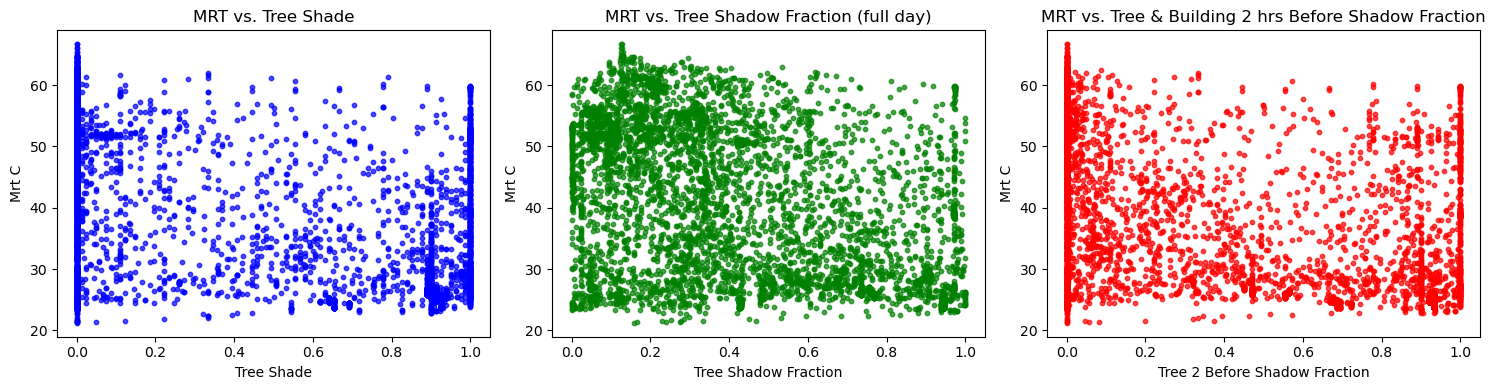

In [29]:
import matplotlib.pyplot as plt

# Define a color list for different scatter plots
color_list = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

# Create a figure and a grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))  # 1 rows, 3 columns

# Scatter plots with colors, labels, and axis names
# scatter_plots = [
#     (0, 0, 'building_shade', 'MRT_C', 'MRT vs. Building Shade'),
#     (1, 0, 'tree_shade', 'MRT_C', 'MRT vs. Tree Shade'),
#     (0, 1, 'bldg_shadow_fraction', 'MRT_C', 'MRT vs. Building Shadow Fraction (full day)'),
#     (1, 1, 'tree_shadow_fraction', 'MRT_C', 'MRT vs. Tree Shadow Fraction (full day)'),
#     (0, 2, 'bldg_2_before_shadow_fraction', 'MRT_C', 'MRT vs. Building 2 hrs Before Shadow Fraction'),
#     (1, 2, 'tree_2_before_shadow_fraction', 'MRT_C', 'MRT vs. Tree & Building 2 hrs Before Shadow Fraction')
# ]
scatter_plots = [
    (0, 0, 'tree_shade', 'MRT_C', 'MRT vs. Tree Shade'),
    (0, 1, 'tree_shadow_fraction', 'MRT_C', 'MRT vs. Tree Shadow Fraction (full day)'),
    (0, 2, 'tree_2_before_shadow_fraction', 'MRT_C', 'MRT vs. Tree & Building 2 hrs Before Shadow Fraction')
]

# Iterate over axes and plot
for i, (x, y, x_col, y_col, title) in enumerate(scatter_plots):
    row, col = x, y  # Get subplot row and column index
    ax = axes[col]

    # Scatter plot with colors and smaller points
    ax.scatter(df[x_col], df[y_col], s=10, c=color_list[i], alpha=0.7)

    # Set title and axis labels
    ax.set_title(title, fontsize=12)
    ax.set_xlabel(x_col.replace("_", " ").title(), fontsize=10)
    ax.set_ylabel(y_col.replace("_", " ").title(), fontsize=10)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Show the plot
plt.show()

#### Correlation Analysis

Add columns with different binning

In [30]:
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])

In [37]:
df_shade_MRT_airtemp_aug = df[df['TIMESTAMP'].dt.month == 8]

In [38]:
df_shade_MRT_airtemp_aug['shade_temp_interaction'] = df_shade_MRT_airtemp_aug['tree_shadow_fraction'] * df_shade_MRT_airtemp_aug['Air_Temp']

In [35]:
directions = ['in', 'out', 'left', 'right', 'front', 'back']

In [36]:
df['E_short_avg'] = df[['E_short_' + d for d in directions]].mean(axis=1)
df['E_long_avg'] = df[['E_long_' + d for d in directions]].mean(axis=1)

In [39]:
df_shade_MRT_airtemp_aug.columns

Index(['RECORD', 'GPSData', 'Air_Temp', 'humidity', 'Qs_in', 'Qs_out',
       'Qs_left', 'Qs_right', 'Qs_front', 'Qs_back', 'QL_in', 'QL_out',
       'QL_left', 'QL_right', 'QL_front', 'QL_back', 'TL_inout', 'TL_leftrig',
       'TL_front', 'TL_back', 'wheelfreq', 'WindDir', 'WS_ms', 'WSDiag',
       'PTemp', 'batt_volt', 'GPSData_ti', 'TIMESTAMP', 'T_sensor_K',
       'L_corr_term', 'E_in', 'E_out', 'E_left', 'E_right', 'E_front',
       'E_back', 'E_avg', 'MRT_K', 'MRT_C', 'E_long_in', 'E_short_in',
       'E_total_in', 'E_long_out', 'E_short_out', 'E_total_out', 'E_long_left',
       'E_short_left', 'E_total_left', 'E_long_right', 'E_short_right',
       'E_total_right', 'E_long_front', 'E_short_front', 'E_total_front',
       'E_long_back', 'E_short_back', 'E_total_back', 'tree_shade',
       'tree_shadow_fraction', 'tree_2_before_shadow_fraction', 'geometry',
       'E_short_avg', 'E_long_avg', 'shade_temp_interaction'],
      dtype='object')

In [ ]:
import statsmodels.api as sm

X = df_shade_MRT_airtemp_aug[['E_long_avg', 'E_']]  # or include 'building_shade', 'bldg_shadow_fraction', etc.
X = sm.add_constant(X)
y = df_shade_MRT_airtemp_aug['MRT_C']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  MRT_C   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     4694.
Date:                Mon, 07 Apr 2025   Prob (F-statistic):               0.00
Time:                        13:34:38   Log-Likelihood:                -21156.
No. Observations:                5792   AIC:                         4.232e+04
Df Residuals:                    5790   BIC:                         4.233e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -195.4697      3.421    -57.135      0.0

In [48]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X = df[['E_short_avg', 'tree_shade']]
vif = pd.DataFrame()
vif["variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

     variables       VIF
0  E_short_avg  1.112416
1   tree_shade  1.112416


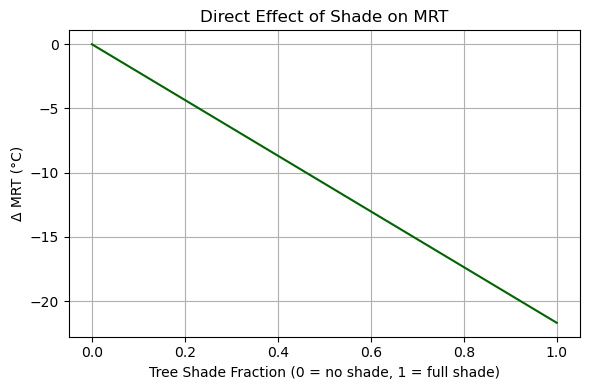

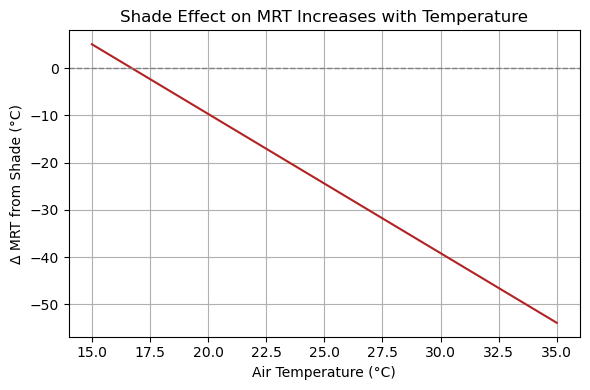

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==== Direct Effect Plot ====
# Coefficients from your earlier model (without interaction)
coef_shade = -21.69
intercept = 0  # we don't need actual intercept here, just delta

shade_range = np.linspace(0, 1, 100)
mrt_direct = intercept + coef_shade * shade_range

plt.figure(figsize=(6, 4))
plt.plot(shade_range, mrt_direct, label='Predicted MRT', color='darkgreen')
plt.xlabel('Tree Shade Fraction (0 = no shade, 1 = full shade)')
plt.ylabel('Δ MRT (°C)')
plt.title('Direct Effect of Shade on MRT')
plt.grid(True)
plt.tight_layout()
plt.savefig("shade_direct_effect.png")
plt.show()

# ==== Interaction Effect Plot ====
# From your interaction model:
# MRT_C = 49.34*shade - 2.95*shade*temp + 5.58*temp
# Let's isolate the effect of 100% shade as a function of temp

temps = np.linspace(15, 35, 100)  # in degrees C
effect_of_shade = 49.34 - 2.95 * temps

plt.figure(figsize=(6, 4))
plt.plot(temps, effect_of_shade, label='Effect of Full Tree Shade on MRT', color='firebrick')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Air Temperature (°C)')
plt.ylabel('Δ MRT from Shade (°C)')
plt.title('Shade Effect on MRT Increases with Temperature')
plt.grid(True)
plt.tight_layout()
plt.savefig("shade_interaction_effect.png")
plt.show()


In [68]:
df_shade_MRT_airtemp_aug['tree_shade_squared'] = df_shade_MRT_airtemp_aug['tree_shadow_fraction'] ** 2

X = df_shade_MRT_airtemp_aug[['tree_shadow_fraction', 'tree_shade_squared', 'Air_Temp']]
X = sm.add_constant(X)
model = sm.OLS(df_shade_MRT_airtemp_aug['MRT_C'], X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  MRT_C   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     1013.
Date:                Mon, 31 Mar 2025   Prob (F-statistic):               0.00
Time:                        15:48:25   Log-Likelihood:                -22078.
No. Observations:                5900   AIC:                         4.416e+04
Df Residuals:                    5896   BIC:                         4.419e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -63.1561 

c:\Users\Dila Ozberkman\miniconda3\envs\shade_env\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [60]:
from patsy import dmatrix
import statsmodels.api as sm

# Generate spline basis
spline = dmatrix("bs(tree_shadow_fraction, df=4, degree=3)", data=df_shade_MRT_airtemp_aug, return_type='dataframe')

# Combine with other predictors
X = pd.concat([spline, df_shade_MRT_airtemp_aug[['Air_Temp']]], axis=1)
X = sm.add_constant(X)
y = df_shade_MRT_airtemp_aug['MRT_C']

# Fit the model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  MRT_C   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     713.5
Date:                Mon, 07 Apr 2025   Prob (F-statistic):               0.00
Time:                        13:40:17   Log-Likelihood:                -21485.
No. Observations:                5792   AIC:                         4.298e+04
Df Residuals:                    5786   BIC:                         4.302e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

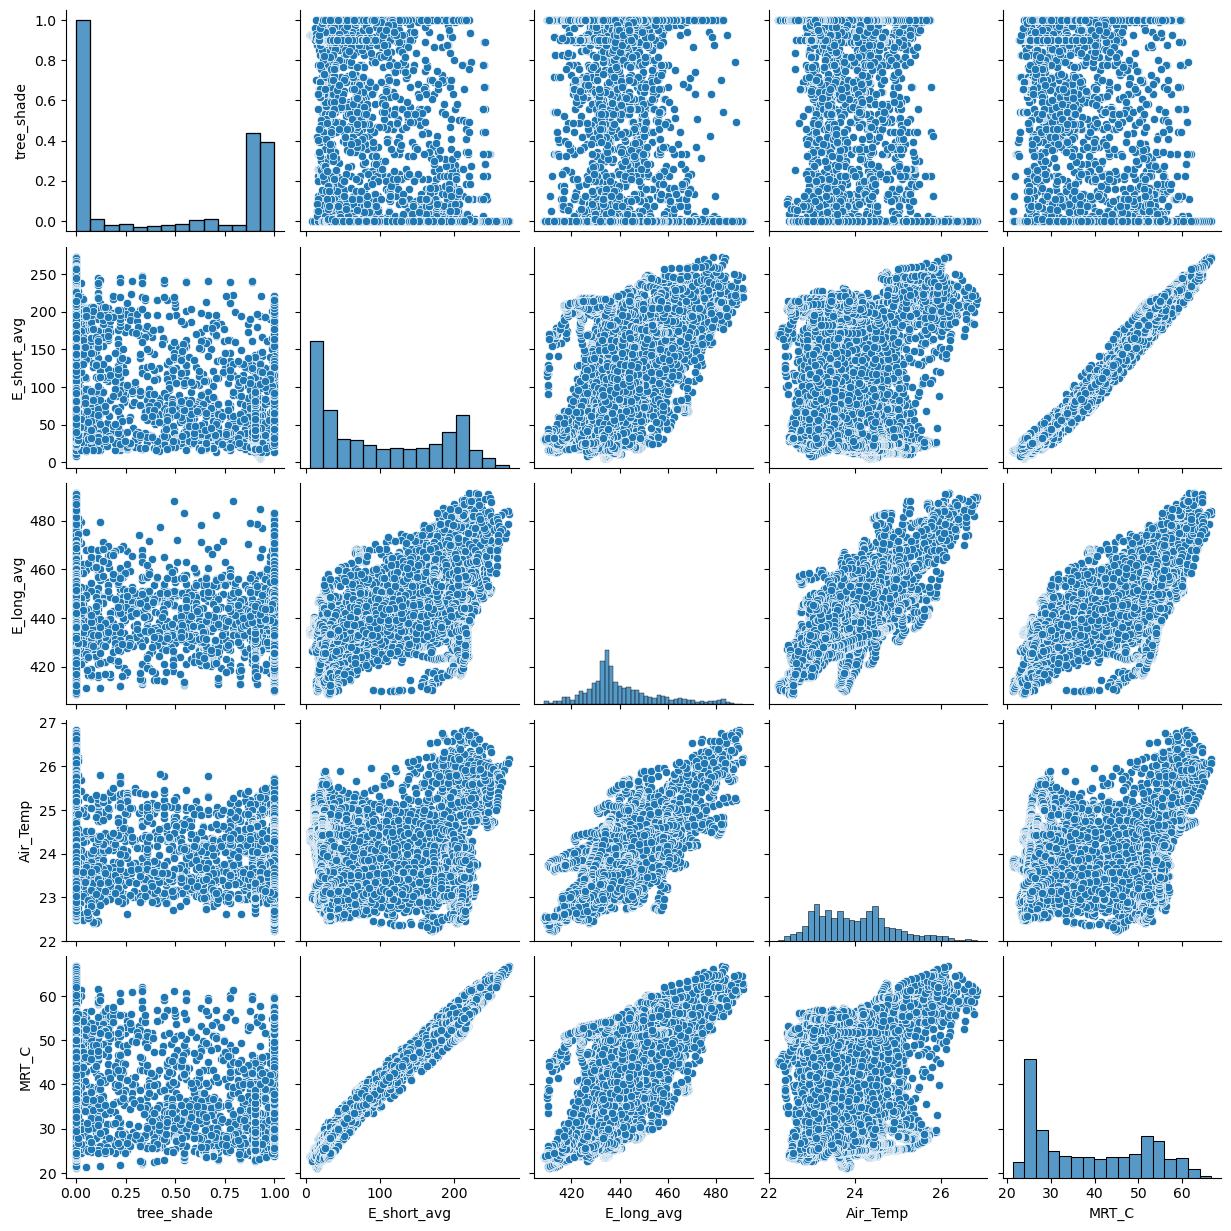

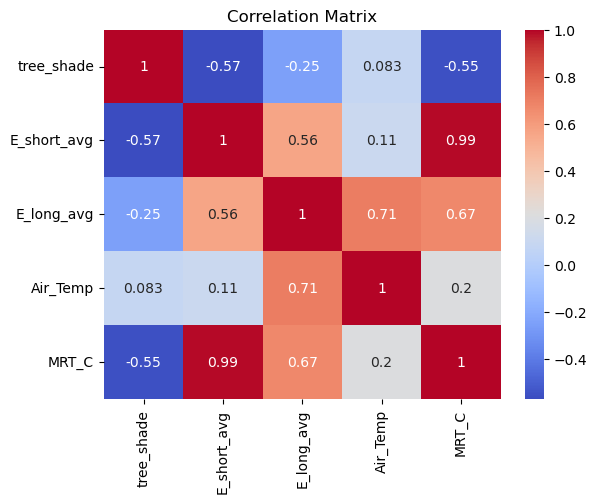

In [61]:
# Pairplot of key variables
sns.pairplot(df[['tree_shade', 'E_short_avg', 'E_long_avg', 'Air_Temp', 'MRT_C']])
plt.show()

# Correlation matrix
sns.heatmap(df[['tree_shade', 'E_short_avg', 'E_long_avg', 'Air_Temp', 'MRT_C']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


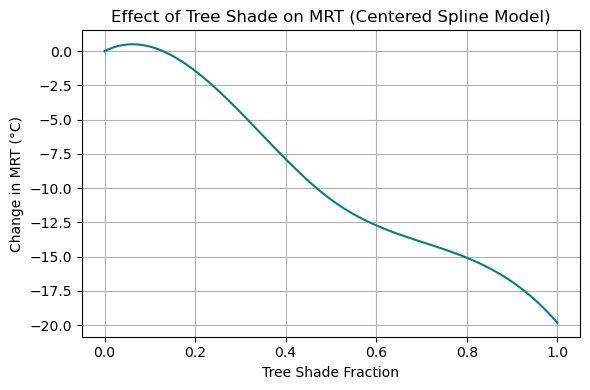

In [76]:
import matplotlib.pyplot as plt
import numpy as np
from patsy import dmatrix

# Define shade range
shade_vals = np.linspace(0, 1, 100)
spline_vals = dmatrix("bs(shade_vals, df=4, degree=3)", {"shade_vals": shade_vals}, return_type='dataframe')

# Get predicted MRT (without intercept/air temp, for simplicity)
coefs = model.params.values[:-1]  # exclude Air_Temp
predicted_mrt = np.dot(spline_vals, coefs)

predicted_mrt_centered = predicted_mrt - predicted_mrt[0]

plt.figure(figsize=(6, 4))
plt.plot(shade_vals, predicted_mrt_centered, color='teal')
plt.xlabel("Tree Shade Fraction")
plt.ylabel("Change in MRT (°C)")
plt.title("Effect of Tree Shade on MRT (Centered Spline Model)")
plt.grid(True)
plt.tight_layout()
plt.show()

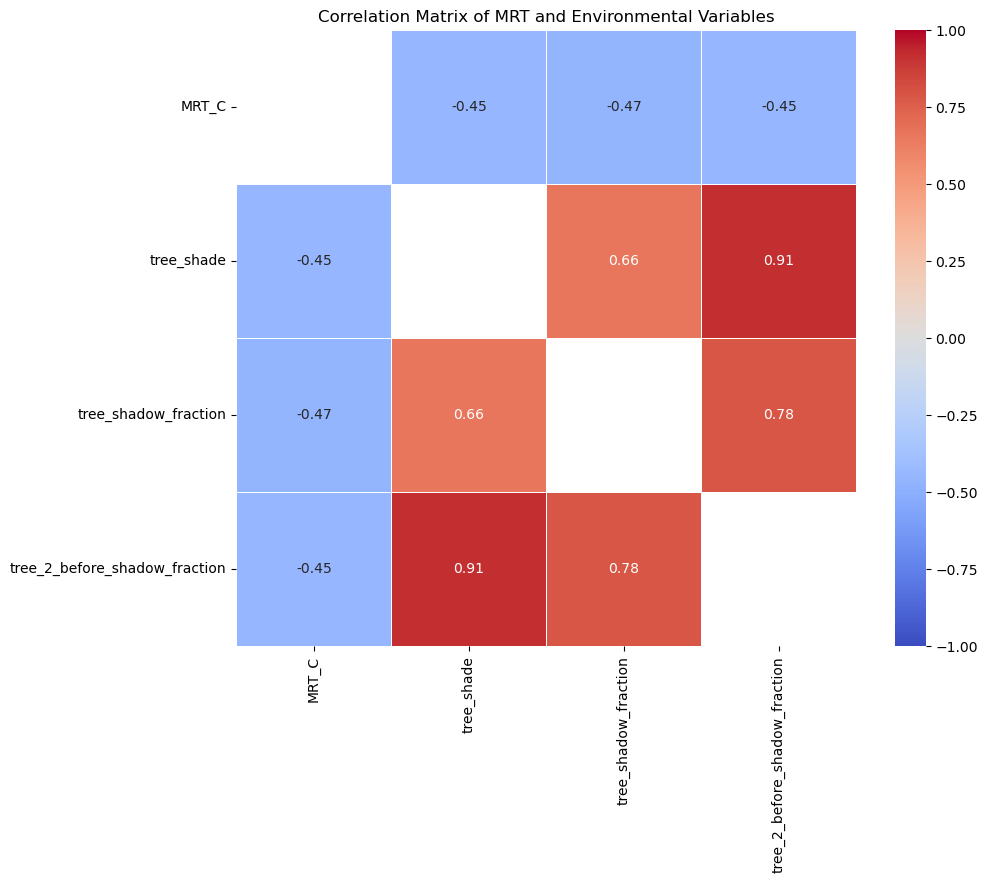

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

columns_of_interest = ['MRT_C', 'tree_shade', 'tree_shadow_fraction', 'tree_2_before_shadow_fraction']

# columns_of_interest = ['MRT_C', 'bldg_hrs_before_shadow_fraction', 'tree_hrs_before_shadow_fraction', 'Air_Temp', 'humidity', 'WS_ms']

# Compute correlation matrix
correlation_matrix = df_shade_MRT_airtemp[columns_of_interest].corr()

# Mask the diagonal
mask = np.eye(len(correlation_matrix), dtype=bool)

# Set up the figure
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    mask=mask,
    linewidths=0.5,
    cbar=True
)

plt.title("Correlation Matrix of MRT and Environmental Variables")
plt.show()

In [48]:
df_shade_MRT_airtemp['Air_Temp'] = df_shade_MRT_airtemp['Air_Temp'].astype('float64')
df_shade_MRT_airtemp['humidity'] = df_shade_MRT_airtemp['humidity'].astype('float64')
df_shade_MRT_airtemp['WS_ms'] = df_shade_MRT_airtemp['WS_ms'].astype('float64')

In [49]:
df_shade_MRT_airtemp.columns

Index(['RECORD', 'GPSData', 'Air_Temp', 'humidity', 'Qs_in', 'Qs_out',
       'Qs_left', 'Qs_right', 'Qs_front', 'Qs_back', 'QL_in', 'QL_out',
       'QL_left', 'QL_right', 'QL_front', 'QL_back', 'TL_inout', 'TL_leftrig',
       'TL_front', 'TL_back', 'wheelfreq', 'WindDir', 'WS_ms', 'WSDiag',
       'PTemp', 'batt_volt', 'GPSData_ti', 'TIMESTAMP', 'T_sensor_K',
       'L_corr_term', 'E_in', 'E_out', 'E_left', 'E_right', 'E_front',
       'E_back', 'E_avg', 'MRT_K', 'MRT_C', 'E_long_in', 'E_short_in',
       'E_total_in', 'E_long_out', 'E_short_out', 'E_total_out', 'E_long_left',
       'E_short_left', 'E_total_left', 'E_long_right', 'E_short_right',
       'E_total_right', 'E_long_front', 'E_short_front', 'E_total_front',
       'E_long_back', 'E_short_back', 'E_total_back', 'tree_shade',
       'tree_shadow_fraction', 'tree_2_before_shadow_fraction', 'geometry'],
      dtype='object')

In [15]:
df_shade_MRT_airtemp['TIMESTAMP'].dtype

dtype('<M8[ms]')

In [16]:
df_shade_MRT_airtemp_aug = df_shade_MRT_airtemp[df_shade_MRT_airtemp['TIMESTAMP'].dt.month == 8]

In [17]:
df_shade_MRT_airtemp['TIMESTAMP'] = pd.to_datetime(df_shade_MRT_airtemp['TIMESTAMP'])

In [18]:
df_shade_MRT_airtemp_aug['TIMESTAMP'].unique()

<DatetimeArray>
['2023-08-23 13:57:00', '2023-08-23 13:58:00', '2023-08-23 13:59:00',
 '2023-08-23 14:00:00', '2023-08-23 14:01:00', '2023-08-23 14:02:00',
 '2023-08-23 14:03:00', '2023-08-23 14:04:00', '2023-08-23 14:05:00',
 '2023-08-23 14:14:00',
 ...
 '2023-08-23 17:20:00', '2023-08-23 17:21:00', '2023-08-23 17:22:00',
 '2023-08-23 17:23:00', '2023-08-23 17:24:00', '2023-08-23 17:25:00',
 '2023-08-23 17:26:00', '2023-08-23 17:27:00', '2023-08-23 17:28:00',
 '2023-08-23 17:29:00']
Length: 128, dtype: datetime64[ms]

There are 1237 points in this interval: 2023-08-23 13:56:00 - 2023-08-23 14:30:00
There are 211 points in this interval: 2023-08-23 14:30:00 - 2023-08-23 15:00:00
There are 1098 points in this interval: 2023-08-23 15:00:00 - 2023-08-23 15:30:00
There are 690 points in this interval: 2023-08-23 15:30:00 - 2023-08-23 16:00:00
There are 1060 points in this interval: 2023-08-23 16:30:00 - 2023-08-23 17:00:00
There are 1496 points in this interval: 2023-08-23 17:00:00 - 2023-08-23 17:30:00


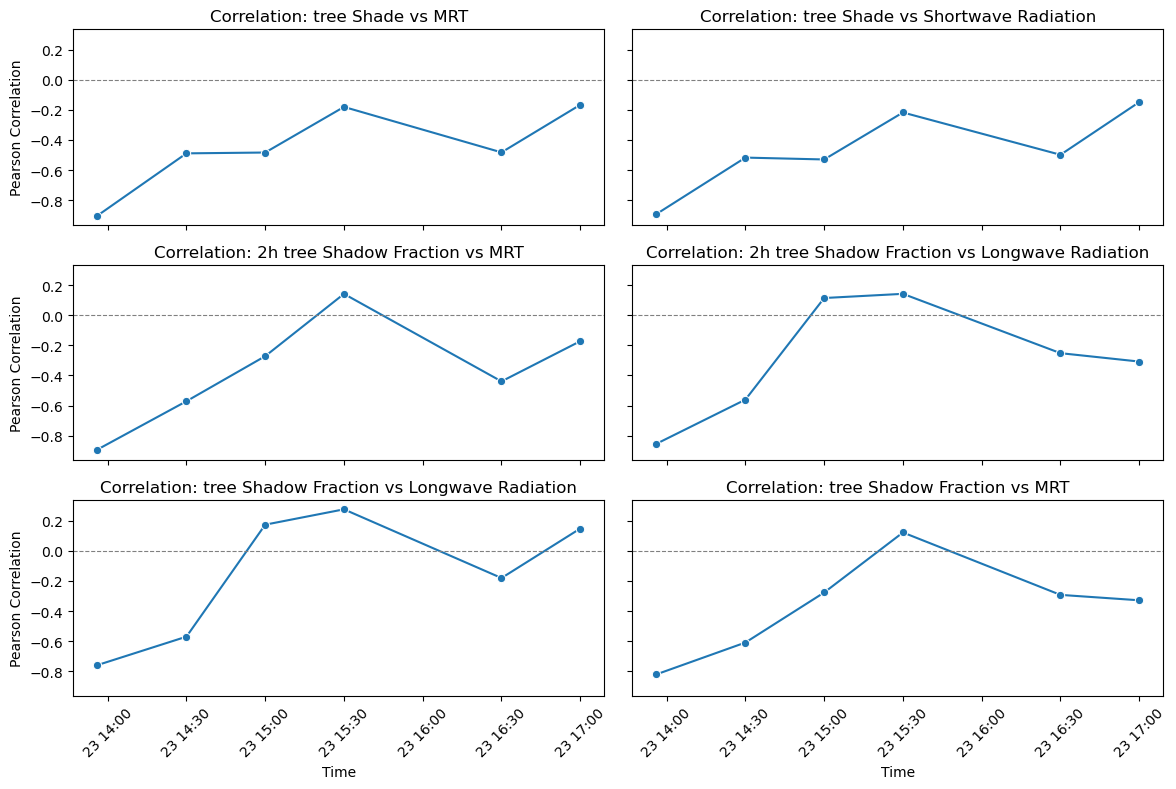

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the time intervals
august_intervals = [
    ('2023-08-23 13:56:00', '2023-08-23 14:30:00'),
    ('2023-08-23 14:30:00', '2023-08-23 15:00:00'),
    ('2023-08-23 15:00:00', '2023-08-23 15:30:00'),
    ('2023-08-23 15:30:00', '2023-08-23 16:00:00'),
    ('2023-08-23 16:30:00', '2023-08-23 17:00:00'),
    ('2023-08-23 17:00:00', '2023-08-23 17:30:00')
]

# Convert the intervals to datetime
august_intervals = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in august_intervals]

# Define the column pairs for correlation calculation
column_pairs = [
    ("tree_shade", "MRT_C", "tree Shade", "MRT"),
    ("tree_shade", "E_short_avg", "tree Shade", "Shortwave Radiation"),
    ("tree_2_before_shadow_fraction", "MRT_C", "2h tree Shadow Fraction", "MRT"),
    ("tree_2_before_shadow_fraction", "E_long_avg", "2h tree Shadow Fraction", "Longwave Radiation"),
    ("tree_shadow_fraction", "E_long_avg", "tree Shadow Fraction", "Longwave Radiation"),
    ("tree_shadow_fraction", "MRT_C", "tree Shadow Fraction", "MRT")
]

# Prepare a dictionary to store correlation values
correlation_data = {pair: [] for pair in column_pairs}
timestamps = []

# Iterate through time intervals and compute correlations
for start, end in august_intervals:
    timestamps.append(start)  # Use start time as x-axis value
    df_interval = df_shade_MRT_airtemp_aug[
        (df_shade_MRT_airtemp_aug['TIMESTAMP'] >= start) &
        (df_shade_MRT_airtemp_aug['TIMESTAMP'] < end)
    ]
    print(f"There are {df_interval.shape[0]} points in this interval: {start} - {end}")

    for col_x, col_y, x_name, y_name in column_pairs:
        if not df_interval.empty:
            correlation = df_interval[col_x].corr(df_interval[col_y])
            correlation_data[(col_x, col_y, x_name, y_name)].append(correlation)
        else:
            correlation_data[(col_x, col_y, x_name, y_name)].append(None)  # Handle empty intervals

# Create a grid of line plots
fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

for idx, ((col_x, col_y, x_name, y_name), cor_values) in enumerate(correlation_data.items()):
    ax = axes[idx]
    sns.lineplot(x=timestamps, y=cor_values, marker='o', ax=ax)
    # Add dashed horizontal line at correlation = 0
    ax.axhline(y=0, linestyle='dashed', linewidth=0.8, color='gray')

    ax.set_title(f"Correlation: {x_name} vs {y_name}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Pearson Correlation")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [28]:
df_shade_MRT.columns

Index(['RECORD', 'GPSData', 'Air_Temp', 'humidity', 'Qs_in', 'Qs_out',
       'Qs_left', 'Qs_right', 'Qs_front', 'Qs_back', 'QL_in', 'QL_out',
       'QL_left', 'QL_right', 'QL_front', 'QL_back', 'TL_inout', 'TL_leftrig',
       'TL_front', 'TL_back', 'wheelfreq', 'WindDir', 'WS_ms', 'WSDiag',
       'PTemp', 'batt_volt', 'GPSData_ti', 'latitude', 'longitude',
       'TIMESTAMP', 'T_sensor_K', 'L_corr_term', 'E_in', 'E_out', 'E_left',
       'E_right', 'E_front', 'E_back', 'E_avg', 'MRT_K', 'MRT_C', 'E_long_in',
       'E_short_in', 'E_total_in', 'E_long_out', 'E_short_out', 'E_total_out',
       'E_long_left', 'E_short_left', 'E_total_left', 'E_long_right',
       'E_short_right', 'E_total_right', 'E_long_front', 'E_short_front',
       'E_total_front', 'E_long_back', 'E_short_back', 'E_total_back',
       'building_shade', 'tree_shade', 'bldg_shadow_fraction',
       'tree_shadow_fraction', 'bldg_2_before_shadow_fraction',
       'tree_2_before_shadow_fraction', 'rounded_timestamp', 

In [ ]:
df_shade_MRT_airtemp_aug[df_shade_MRT_airtemp_aug['tree_shade'] == 1][['building_shade', 'tree_shade']]

,building_shade,tree_shade
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
...,...,...
5652,1.0,1.0
5653,1.0,1.0
5654,1.0,1.0
5655,1.0,1.0


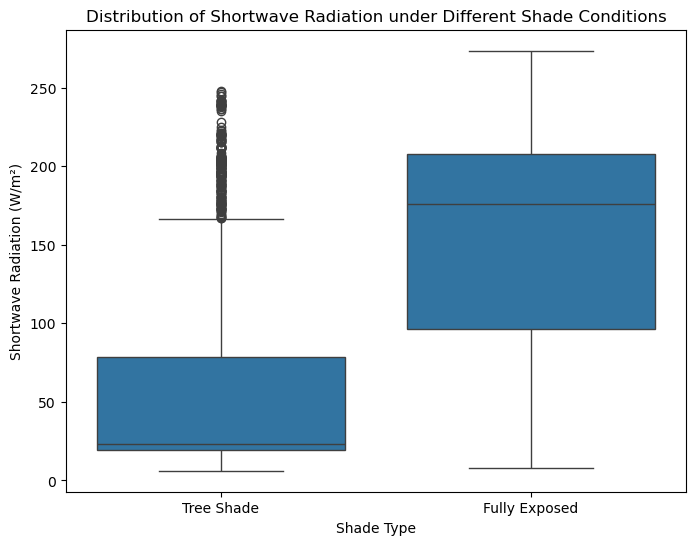

In [22]:
# # Define the three filtering conditions
# df_building_shade_only = df_shade_MRT_airtemp_aug[(df_shade_MRT_airtemp_aug['building_shade'] == 1)].copy()

df_tree_shade_only = df_shade_MRT_airtemp_aug[
    (df_shade_MRT_airtemp_aug['tree_shade'] != 1) & (df_shade_MRT_airtemp_aug['tree_shade'] != 0)
].copy()

df_fully_exposed = df_shade_MRT_airtemp_aug[
    (df_shade_MRT_airtemp_aug['tree_shade'] == 0)
].copy()

# Add a column to label each dataset category
# df_building_shade_only['Shade Type'] = 'Building Shade'
df_tree_shade_only['Shade Type'] = 'Tree Shade'
df_fully_exposed['Shade Type'] = 'Fully Exposed'

# Combine all datasets
df_combined = pd.concat([df_tree_shade_only, df_fully_exposed])

# Create the box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Shade Type', y='E_short_avg', data=df_combined)

# Customize plot
plt.title("Distribution of Shortwave Radiation under Different Shade Conditions")
plt.ylabel("Shortwave Radiation (W/m²)")
plt.xlabel("Shade Type")

# Show plot
plt.show()

In [ ]:
# Step 1: Group by 'Shade Type' if you're analyzing by category

q1 = df_building_shade_only['E_short_avg'].quantile(0.25)
q3 = df_building_shade_only['E_short_avg'].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Step 2: Get the outliers for this group
group_outliers = df_building_shade_only[
    (df_building_shade_only['E_short_avg'] < lower_bound) | (df_building_shade_only['E_short_avg'] > upper_bound)
]

group_outliers = gpd.GeoDataFrame(group_outliers, geometry='geometry')

In [ ]:
group_outliers.columns

Index(['RECORD', 'GPSData', 'Air_Temp', 'humidity', 'Qs_in', 'Qs_out',
       'Qs_left', 'Qs_right', 'Qs_front', 'Qs_back', 'QL_in', 'QL_out',
       'QL_left', 'QL_right', 'QL_front', 'QL_back', 'TL_inout', 'TL_leftrig',
       'TL_front', 'TL_back', 'wheelfreq', 'WindDir', 'WS_ms', 'WSDiag',
       'PTemp', 'batt_volt', 'GPSData_ti', 'latitude', 'longitude',
       'TIMESTAMP', 'T_sensor_K', 'L_corr_term', 'E_in', 'E_out', 'E_left',
       'E_right', 'E_front', 'E_back', 'E_avg', 'MRT_K', 'MRT_C', 'E_long_in',
       'E_short_in', 'E_total_in', 'E_long_out', 'E_short_out', 'E_total_out',
       'E_long_left', 'E_short_left', 'E_total_left', 'E_long_right',
       'E_short_right', 'E_total_right', 'E_long_front', 'E_short_front',
       'E_total_front', 'E_long_back', 'E_short_back', 'E_total_back',
       'building_shade', 'tree_shade', 'bldg_shadow_fraction',
       'tree_shadow_fraction', 'bldg_2_before_shadow_fraction',
       'tree_2_before_shadow_fraction', 'rounded_timestamp', 

In [ ]:
group_outliers.to_file("../data/clean_data/additional/e6a08fb8/building_shade_shortwave_exposure_outliers.geojson", driver='GEOJSON')

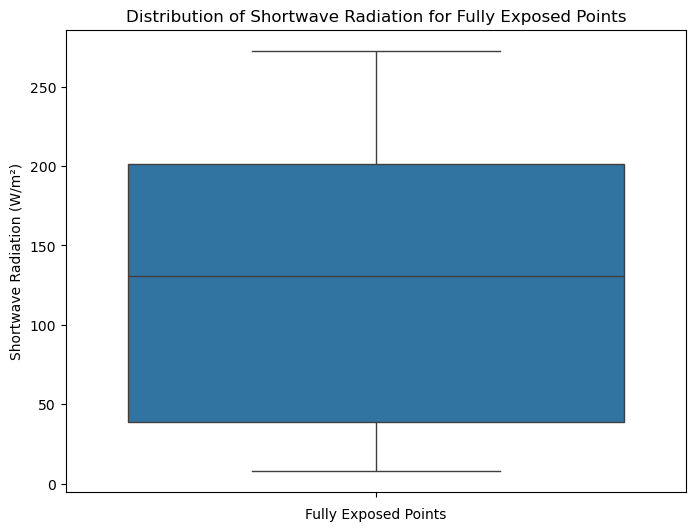

In [ ]:
# Filter for fully exposed points (no tree shade, no building shade)
df_no_shaded = df_shade_MRT_airtemp_aug[
    (df_shade_MRT_airtemp_aug['tree_shade'] == 0) & (df_shade_MRT_airtemp_aug['building_shade'] == 0)
]

# Create the box plot directly
plt.figure(figsize=(8, 6))
sns.boxplot(y=df_no_shaded['E_short_avg'])

# Customize the plot
plt.title("Distribution of Shortwave Radiation for Fully Exposed Points")
plt.ylabel("Shortwave Radiation (W/m²)")
plt.xlabel("Fully Exposed Points")

# Show the plot
plt.show()


In [64]:
df_shade_MRT_sept = df_shade_MRT[df_shade_MRT['TIMESTAMP'].dt.month == 9]

In [65]:
df_shade_MRT_sept['TIMESTAMP'].unique()

<DatetimeArray>
[]
Length: 0, dtype: datetime64[ms]

There are 108 points in this interval: 2023-09-12 10:00:00 - 2023-09-12 10:30:00
There are 935 points in this interval: 2023-09-12 10:30:00 - 2023-09-12 11:00:00
There are 1790 points in this interval: 2023-09-12 11:30:00 - 2023-09-12 12:00:00
There are 1399 points in this interval: 2023-09-12 12:00:00 - 2023-09-12 12:30:00
There are 577 points in this interval: 2023-09-12 12:30:00 - 2023-09-12 13:00:00
There are 645 points in this interval: 2023-09-12 14:00:00 - 2023-09-12 14:30:00
There are 633 points in this interval: 2023-09-12 15:00:00 - 2023-09-12 15:40:00


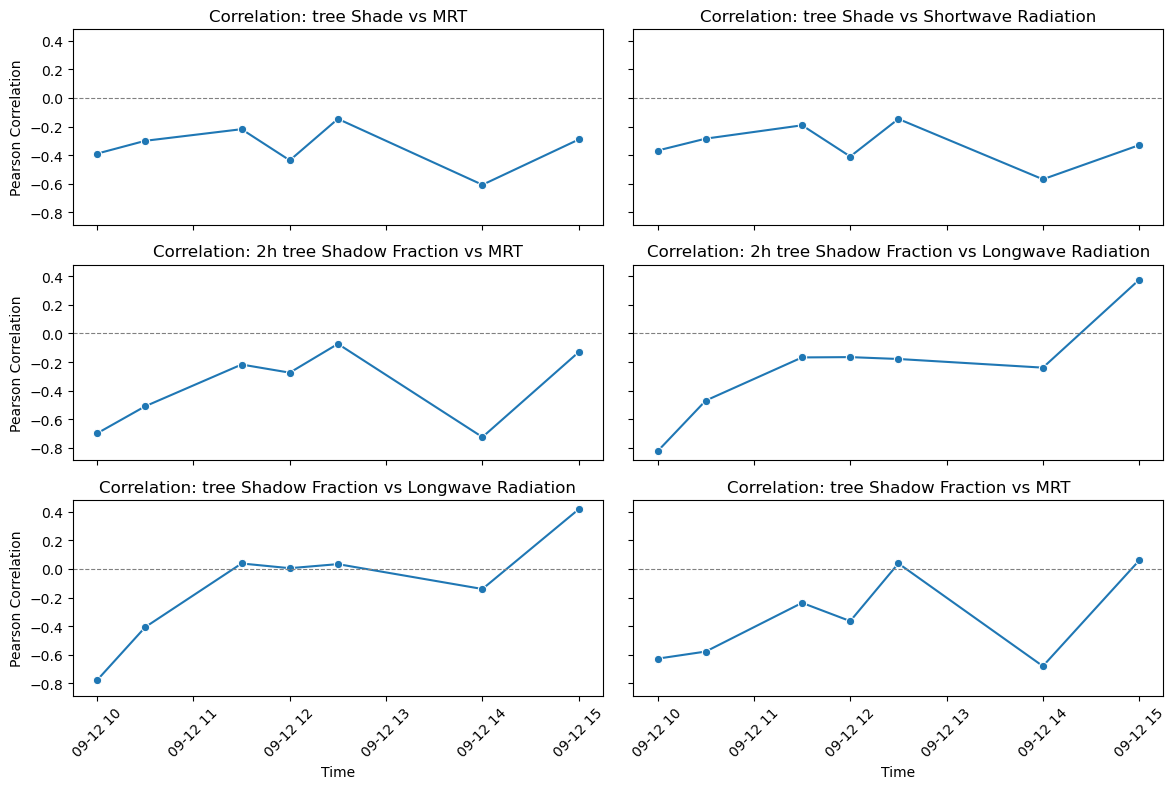

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the time intervals
sept_intervals = [
    ('2023-09-12 10:00:00', '2023-09-12 10:30:00'),
    ('2023-09-12 10:30:00', '2023-09-12 11:00:00'),
    ('2023-09-12 11:30:00', '2023-09-12 12:00:00'),
    ('2023-09-12 12:00:00', '2023-09-12 12:30:00'),
    ('2023-09-12 12:30:00', '2023-09-12 13:00:00'),
    ('2023-09-12 14:00:00', '2023-09-12 14:30:00'),
    ('2023-09-12 15:00:00', '2023-09-12 15:40:00')
]

# Convert the intervals to datetime
sept_intervals = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in sept_intervals]

# Define the column pairs for correlation calculation
column_pairs = [
    ("tree_shade", "MRT_C", "tree Shade", "MRT"),
    ("tree_shade", "E_short_avg", "tree Shade", "Shortwave Radiation"),
    ("tree_2_before_shadow_fraction", "MRT_C", "2h tree Shadow Fraction", "MRT"),
    ("tree_2_before_shadow_fraction", "E_long_avg", "2h tree Shadow Fraction", "Longwave Radiation"),
    ("tree_shadow_fraction", "E_long_avg", "tree Shadow Fraction", "Longwave Radiation"),
    ("tree_shadow_fraction", "MRT_C", "tree Shadow Fraction", "MRT")
]

# Prepare a dictionary to store correlation values
correlation_data = {pair: [] for pair in column_pairs}
timestamps = []

# Iterate through time intervals and compute correlations
for start, end in sept_intervals:
    timestamps.append(start)  # Use start time as x-axis value
    df_interval = df_shade_MRT_sept[
        (df_shade_MRT_sept['TIMESTAMP'] >= start) &
        (df_shade_MRT_sept['TIMESTAMP'] < end)
    ]
    print(f"There are {df_interval.shape[0]} points in this interval: {start} - {end}")

    for col_x, col_y, x_name, y_name in column_pairs:
        if not df_interval.empty:
            correlation = df_interval[col_x].corr(df_interval[col_y])
            correlation_data[(col_x, col_y, x_name, y_name)].append(correlation)
        else:
            correlation_data[(col_x, col_y, x_name, y_name)].append(None)  # Handle empty intervals

# Create a grid of line plots
fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

for idx, ((col_x, col_y, x_name, y_name), cor_values) in enumerate(correlation_data.items()):
    ax = axes[idx]
    sns.lineplot(x=timestamps, y=cor_values, marker='o', ax=ax)
    # Add dashed horizontal line at correlation = 0
    ax.axhline(y=0, linestyle='dashed', linewidth=0.8, color='gray')

    ax.set_title(f"Correlation: {x_name} vs {y_name}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Pearson Correlation")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [67]:
df_shade_MRT_airtemp_aug = df_shade_MRT

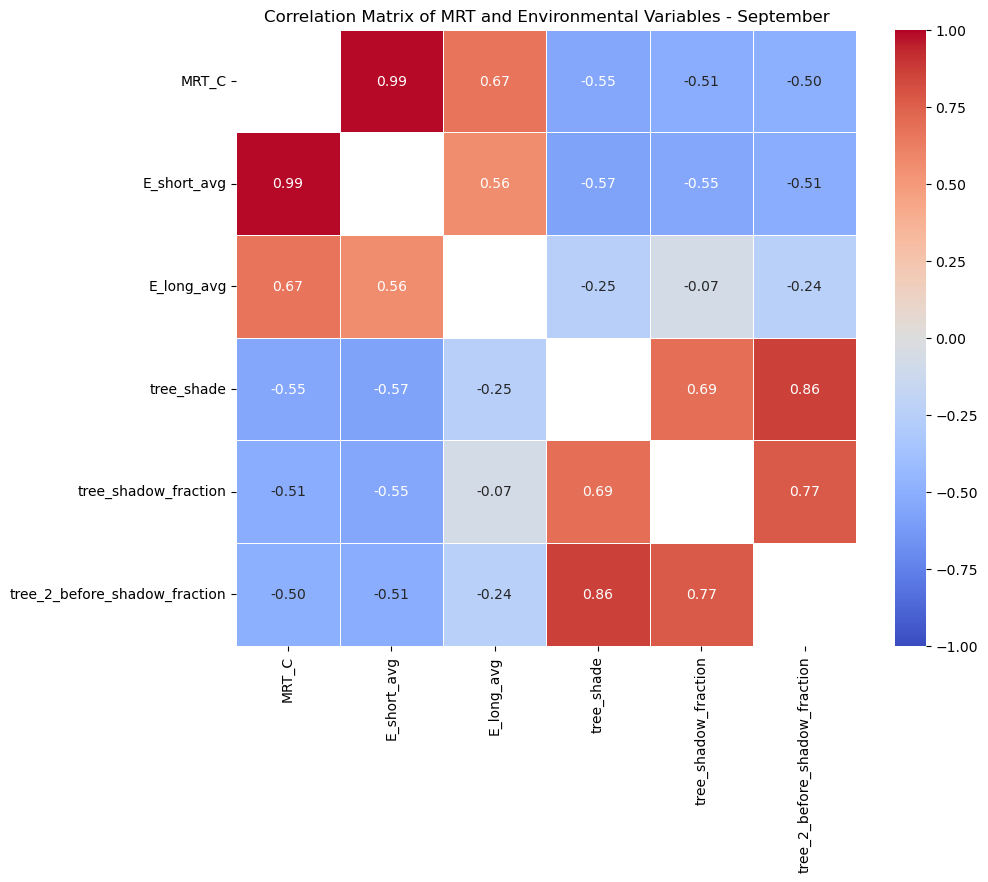

In [23]:
# columns_of_interest = ['MRT_C', 'E_short_avg', 'E_long_avg', 'building_shade', 'tree_shade', 'bldg_shadow_fraction',
#                        'tree_shadow_fraction', 'bldg_hrs_before_shadow_fraction', 'tree_hrs_before_shadow_fraction']

# columns_of_interest = ['MRT_C', 'E_short_avg', 'E_long_avg', 'tree_shade',
#                        'tree_shadow_fraction', 'tree_2_before_shadow_fraction']

columns_of_interest = ['MRT_C', 'E_short_avg', 'E_long_avg', 'tree_shade', 'tree_shadow_fraction', 'tree_2_before_shadow_fraction']

# columns_of_interest = ['MRT_C', 'bldg_hrs_before_shadow_fraction', 'tree_hrs_before_shadow_fraction', 'Air_Temp', 'humidity', 'WS_ms']

# Compute correlation matrix
correlation_matrix = df_shade_MRT_airtemp_aug[columns_of_interest].corr()

# Mask the diagonal
mask = np.eye(len(correlation_matrix), dtype=bool)

# Set up the figure
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    mask=mask,
    linewidths=0.5,
    cbar=True
)

plt.title("Correlation Matrix of MRT and Environmental Variables - September")
plt.show()

### Looking at directional radiation 

In [33]:
df_shade_MRT.columns

Index(['RECORD', 'GPSData', 'Air_Temp', 'humidity', 'Qs_in', 'Qs_out',
       'Qs_left', 'Qs_right', 'Qs_front', 'Qs_back', 'QL_in', 'QL_out',
       'QL_left', 'QL_right', 'QL_front', 'QL_back', 'TL_inout', 'TL_leftrig',
       'TL_front', 'TL_back', 'wheelfreq', 'WindDir', 'WS_ms', 'WSDiag',
       'PTemp', 'batt_volt', 'GPSData_ti', 'latitude', 'longitude',
       'TIMESTAMP', 'T_sensor_K', 'L_corr_term', 'E_in', 'E_out', 'E_left',
       'E_right', 'E_front', 'E_back', 'E_avg', 'MRT_K', 'MRT_C', 'E_long_in',
       'E_short_in', 'E_total_in', 'E_long_out', 'E_short_out', 'E_total_out',
       'E_long_left', 'E_short_left', 'E_total_left', 'E_long_right',
       'E_short_right', 'E_total_right', 'E_long_front', 'E_short_front',
       'E_total_front', 'E_long_back', 'E_short_back', 'E_total_back',
       'building_shade', 'tree_shade', 'bldg_shadow_fraction',
       'tree_shadow_fraction', 'bldg_2_before_shadow_fraction',
       'tree_2_before_shadow_fraction', 'rounded_timestamp', 

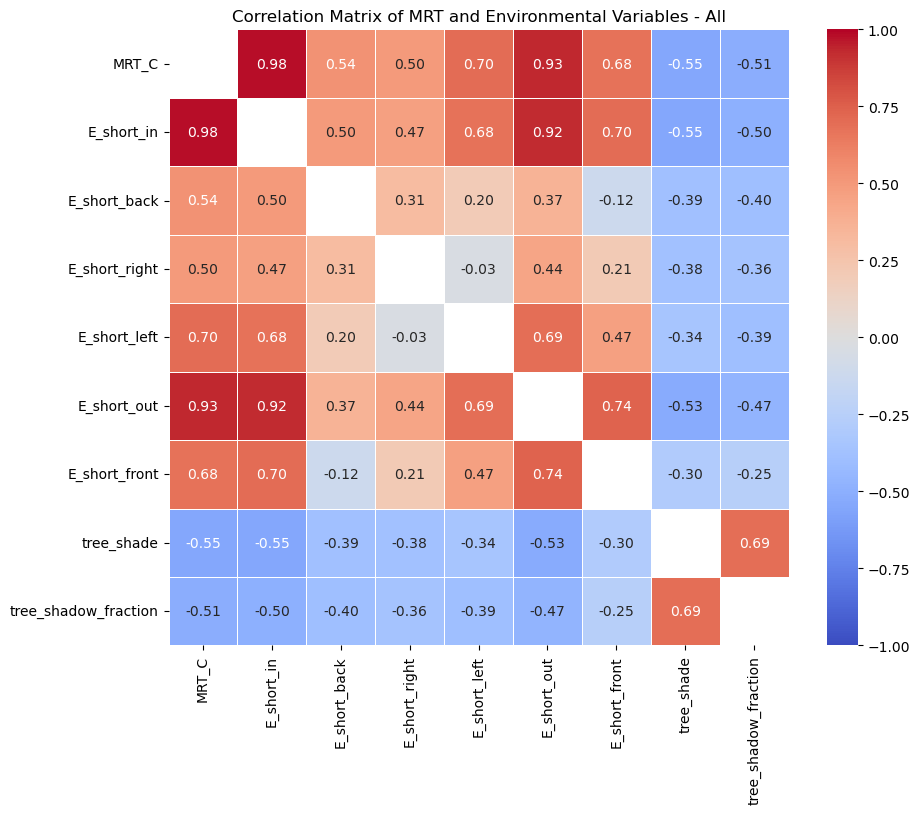

In [24]:
columns_of_interest = ['MRT_C', 'E_short_in', 'E_short_back', 'E_short_right',
                       'E_short_left', 'E_short_out', 'E_short_front', 'tree_shade', 'tree_shadow_fraction']

# Compute correlation matrix
correlation_matrix = df_shade_MRT_airtemp_aug[columns_of_interest].corr()

# Mask the diagonal
mask = np.eye(len(correlation_matrix), dtype=bool)

# Set up the figure
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    mask=mask,
    linewidths=0.5,
    cbar=True
)

plt.title("Correlation Matrix of MRT and Environmental Variables - All")
plt.show()

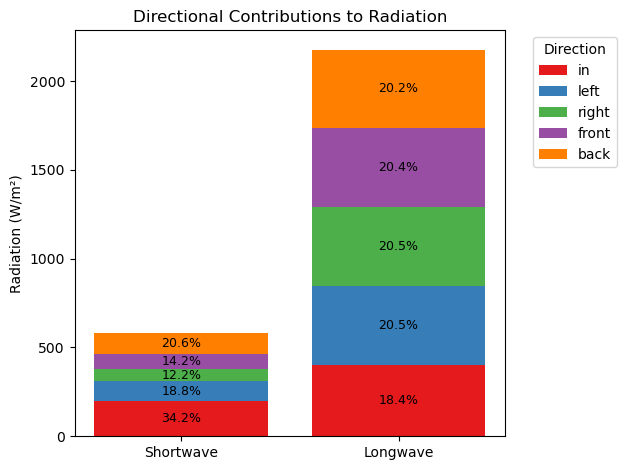

In [25]:
# Directions
directions = ['in', 'left', 'right', 'front', 'back']

# Get average values
shortwave_avgs = [df_shade_MRT[f"E_short_{d}"].mean() for d in directions]
longwave_avgs = [df_shade_MRT[f"E_long_{d}"].mean() for d in directions]

# Totals
total_short = sum(shortwave_avgs)
total_long = sum(longwave_avgs)

# Bar setup
bar_width = 0.4
x = [0, 1]
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']
labels = ['Shortwave', 'Longwave']

fig, ax = plt.subplots()

bottom_short = 0
bottom_long = 0

for i, direction in enumerate(directions):
    # Plot shortwave segment
    sw_value = shortwave_avgs[i]
    ax.bar(x[0], sw_value, bottom=bottom_short, color=colors[i], label=direction if x[0] == 0 else "")
    # Add text
    if sw_value > 0:
        percent = sw_value / total_short * 100
        ax.text(x[0], bottom_short + sw_value / 2, f"{percent:.1f}%", ha='center', va='center', color='black', fontsize=9)
    bottom_short += sw_value

    # Plot longwave segment
    lw_value = longwave_avgs[i]
    ax.bar(x[1], lw_value, bottom=bottom_long, color=colors[i])
    # Add text
    if lw_value > 0:
        percent = lw_value / total_long * 100
        ax.text(x[1], bottom_long + lw_value / 2, f"{percent:.1f}%", ha='center', va='center', color='black', fontsize=9)
    bottom_long += lw_value

# Axes and formatting
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Radiation (W/m²)")
ax.set_title("Directional Contributions to Radiation")
ax.legend(title="Direction", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

There are 1237 points in this interval: 2023-08-23 13:56:00 - 2023-08-23 14:30:00
There are 211 points in this interval: 2023-08-23 14:30:00 - 2023-08-23 15:00:00
There are 1098 points in this interval: 2023-08-23 15:00:00 - 2023-08-23 15:30:00
There are 690 points in this interval: 2023-08-23 15:30:00 - 2023-08-23 16:00:00
There are 1060 points in this interval: 2023-08-23 16:30:00 - 2023-08-23 17:00:00
There are 1496 points in this interval: 2023-08-23 17:00:00 - 2023-08-23 17:30:00


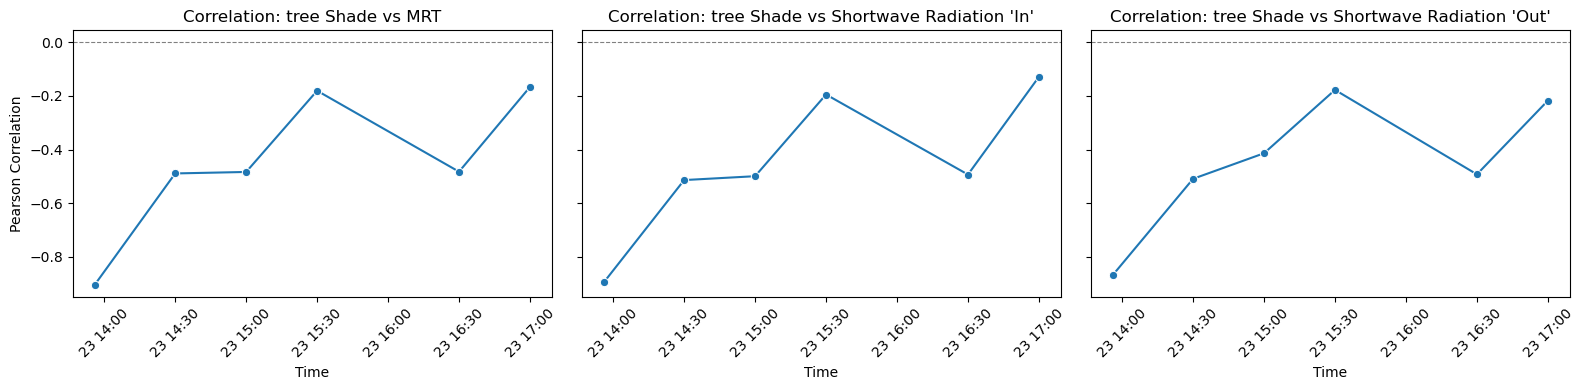

In [27]:
# Define the time intervals
august_intervals = [
    ('2023-08-23 13:56:00', '2023-08-23 14:30:00'),
    ('2023-08-23 14:30:00', '2023-08-23 15:00:00'),
    ('2023-08-23 15:00:00', '2023-08-23 15:30:00'),
    ('2023-08-23 15:30:00', '2023-08-23 16:00:00'),
    ('2023-08-23 16:30:00', '2023-08-23 17:00:00'),
    ('2023-08-23 17:00:00', '2023-08-23 17:30:00')
]

# Convert the intervals to datetime
august_intervals = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in august_intervals]

# Define the column pairs for correlation calculation
column_pairs = [
    ("tree_shade", "MRT_C", "tree Shade", "MRT"),
    ("tree_shade", "E_short_in", "tree Shade", "Shortwave Radiation 'In'"),
    ("tree_shade", "E_short_out", "tree Shade", "Shortwave Radiation 'Out'")
]

# Prepare a dictionary to store correlation values
correlation_data = {pair: [] for pair in column_pairs}
timestamps = []

# Iterate through time intervals and compute correlations
for start, end in august_intervals:
    timestamps.append(start)  # Use start time as x-axis value
    df_interval = df_shade_MRT_airtemp_aug[
        (df_shade_MRT_airtemp_aug['TIMESTAMP'] >= start) &
        (df_shade_MRT_airtemp_aug['TIMESTAMP'] < end)
    ]
    print(f"There are {df_interval.shape[0]} points in this interval: {start} - {end}")

    for col_x, col_y, x_name, y_name in column_pairs:
        if not df_interval.empty:
            correlation = df_interval[col_x].corr(df_interval[col_y])
            correlation_data[(col_x, col_y, x_name, y_name)].append(correlation)
        else:
            correlation_data[(col_x, col_y, x_name, y_name)].append(None)  # Handle empty intervals

# Create a grid of line plots
fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharex=True, sharey=True)
axes = axes.flatten()

for idx, ((col_x, col_y, x_name, y_name), cor_values) in enumerate(correlation_data.items()):
    ax = axes[idx]
    sns.lineplot(x=timestamps, y=cor_values, marker='o', ax=ax)
    # Add dashed horizontal line at correlation = 0
    ax.axhline(y=0, linestyle='dashed', linewidth=0.8, color='gray')

    ax.set_title(f"Correlation: {x_name} vs {y_name}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Pearson Correlation")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

There are 208 points in this interval: 2023-09-12 09:30:00 - 2023-09-12 10:00:00
There are 108 points in this interval: 2023-09-12 10:00:00 - 2023-09-12 10:30:00
There are 935 points in this interval: 2023-09-12 10:30:00 - 2023-09-12 11:00:00
There are 1790 points in this interval: 2023-09-12 11:30:00 - 2023-09-12 12:00:00
There are 1399 points in this interval: 2023-09-12 12:00:00 - 2023-09-12 12:30:00
There are 577 points in this interval: 2023-09-12 12:30:00 - 2023-09-12 13:00:00
There are 645 points in this interval: 2023-09-12 14:00:00 - 2023-09-12 14:30:00
There are 633 points in this interval: 2023-09-12 15:00:00 - 2023-09-12 15:40:00


c:\Users\Dila Ozberkman\miniconda3\envs\shade_env\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Dila Ozberkman\miniconda3\envs\shade_env\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


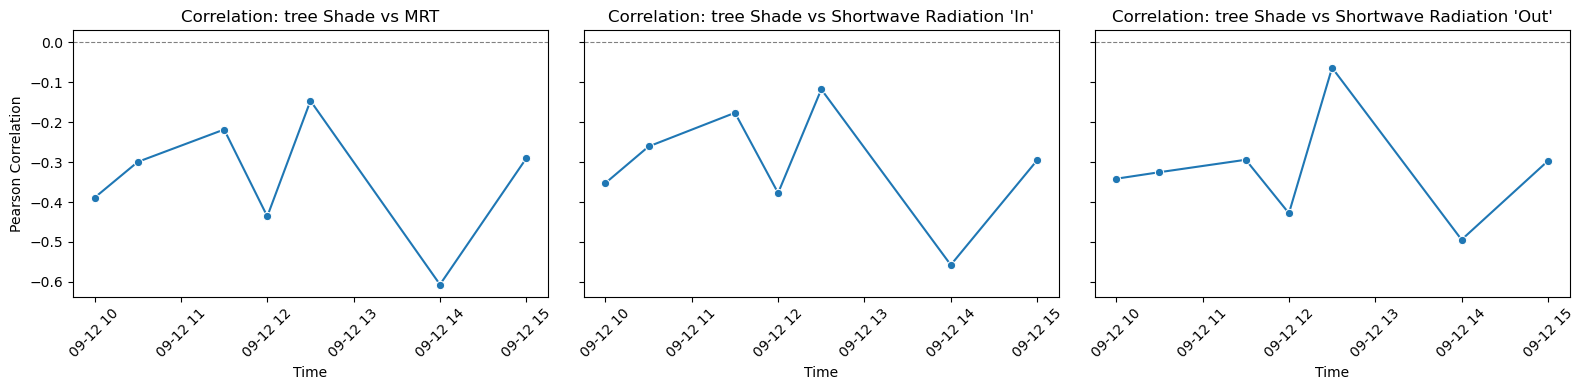

In [42]:
# Define the time intervals
sept_intervals = [
    ('2023-09-12 09:30:00', '2023-09-12 10:00:00'),
    ('2023-09-12 10:00:00', '2023-09-12 10:30:00'),
    ('2023-09-12 10:30:00', '2023-09-12 11:00:00'),
    ('2023-09-12 11:30:00', '2023-09-12 12:00:00'),
    ('2023-09-12 12:00:00', '2023-09-12 12:30:00'),
    ('2023-09-12 12:30:00', '2023-09-12 13:00:00'),
    ('2023-09-12 14:00:00', '2023-09-12 14:30:00'),
    ('2023-09-12 15:00:00', '2023-09-12 15:40:00')
]

# Convert the intervals to datetime
sept_intervals = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in sept_intervals]

# Define the column pairs for correlation calculation
column_pairs = [
    ("tree_shade", "MRT_C", "tree Shade", "MRT"),
    ("tree_shade", "E_short_in", "tree Shade", "Shortwave Radiation 'In'"),
    ("tree_shade", "E_short_out", "tree Shade", "Shortwave Radiation 'Out'")
]

# Prepare a dictionary to store correlation values
correlation_data = {pair: [] for pair in column_pairs}
timestamps = []

# Iterate through time intervals and compute correlations
for start, end in sept_intervals:
    timestamps.append(start)  # Use start time as x-axis value
    df_interval = df_shade_MRT_sept[
        (df_shade_MRT_sept['TIMESTAMP'] >= start) &
        (df_shade_MRT_sept['TIMESTAMP'] < end)
    ]
    print(f"There are {df_interval.shape[0]} points in this interval: {start} - {end}")

    for col_x, col_y, x_name, y_name in column_pairs:
        if not df_interval.empty:
            correlation = df_interval[col_x].corr(df_interval[col_y])
            correlation_data[(col_x, col_y, x_name, y_name)].append(correlation)
        else:
            correlation_data[(col_x, col_y, x_name, y_name)].append(None)  # Handle empty intervals

# Create a grid of line plots
fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharex=True, sharey=True)
axes = axes.flatten()

for idx, ((col_x, col_y, x_name, y_name), cor_values) in enumerate(correlation_data.items()):
    ax = axes[idx]
    sns.lineplot(x=timestamps, y=cor_values, marker='o', ax=ax)
    # Add dashed horizontal line at correlation = 0
    ax.axhline(y=0, linestyle='dashed', linewidth=0.8, color='gray')

    ax.set_title(f"Correlation: {x_name} vs {y_name}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Pearson Correlation")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [21]:
df_shade_MRT_airtemp_aug.columns

Index(['RECORD', 'GPSData', 'Air_Temp', 'humidity', 'Qs_in', 'Qs_out',
       'Qs_left', 'Qs_right', 'Qs_front', 'Qs_back', 'QL_in', 'QL_out',
       'QL_left', 'QL_right', 'QL_front', 'QL_back', 'TL_inout', 'TL_leftrig',
       'TL_front', 'TL_back', 'wheelfreq', 'WindDir', 'WS_ms', 'WSDiag',
       'PTemp', 'batt_volt', 'GPSData_ti', 'latitude', 'longitude',
       'TIMESTAMP', 'T_sensor_K', 'L_corr_term', 'E_in', 'E_out', 'E_left',
       'E_right', 'E_front', 'E_back', 'E_avg', 'MRT_K', 'MRT_C', 'E_long_in',
       'E_short_in', 'E_total_in', 'E_long_out', 'E_short_out', 'E_total_out',
       'E_long_left', 'E_short_left', 'E_total_left', 'E_long_right',
       'E_short_right', 'E_total_right', 'E_long_front', 'E_short_front',
       'E_total_front', 'E_long_back', 'E_short_back', 'E_total_back',
       'building_shade', 'tree_shade', 'bldg_shadow_fraction',
       'tree_shadow_fraction', 'bldg_2_before_shadow_fraction',
       'tree_2_before_shadow_fraction', 'rounded_timestamp', 

number of shaded: 257, number of exposed:417


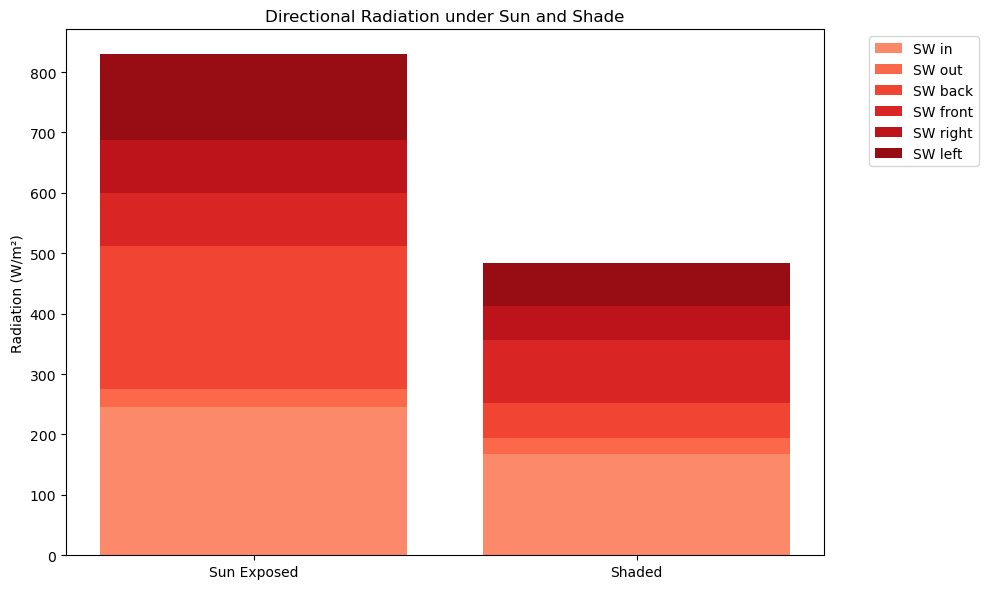

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# 1. Filter based on tree_shade
shade_threshold = 0.95
sun_threshold = 0.05

df_shaded = df_shade_MRT_airtemp_aug[df_shade_MRT_airtemp_aug['tree_shadow_fraction'] > shade_threshold]
df_sun = df_shade_MRT_airtemp_aug[df_shade_MRT_airtemp_aug['tree_shadow_fraction'] < sun_threshold]

print(f"number of shaded: {len(df_shaded)}, number of exposed:{len(df_sun)}")

# 2. Define directional columns
sw_cols = ['E_short_in', 'E_short_out', 'E_short_back', 'E_short_front', 'E_short_right', 'E_short_left']
lw_cols = ['E_long_in', 'E_long_out', 'E_long_back', 'E_long_front', 'E_long_right', 'E_long_left']

# 3. Compute mean values
shaded_means = df_shaded[sw_cols + lw_cols].mean()
sun_means = df_sun[sw_cols + lw_cols].mean()

# 4. Create stacked bar data
labels = ['Sun Exposed', 'Shaded']
shortwave_stack = [sun_means[sw_cols].values, shaded_means[sw_cols].values]
longwave_stack = [sun_means[lw_cols].values, shaded_means[lw_cols].values]

# 5. Generate color gradients
sw_colors = plt.cm.Reds(np.linspace(0.4, 0.9, len(sw_cols)))    # From soft to deep red
lw_colors = plt.cm.Greens(np.linspace(0.4, 0.9, len(lw_cols)))  # From soft to deep green

# 5. Plot
fig, ax = plt.subplots(figsize=(10, 6))

bottom = [0, 0]
# Longwave (Green tones)
# for i, dir in enumerate(lw_cols):
#     values = [longwave_stack[0][i], longwave_stack[1][i]]
#     ax.bar(labels, values, bottom=bottom, label=f'LW {dir.split("_")[2]}', color=lw_colors[i])
#     bottom = [bottom[j] + values[j] for j in range(2)]

# Shortwave (Red tones)
for i, dir in enumerate(sw_cols):
    values = [shortwave_stack[0][i], shortwave_stack[1][i]]
    ax.bar(labels, values, bottom=bottom, label=f'SW {dir.split("_")[2]}', color=sw_colors[i])
    bottom = [bottom[j] + values[j] for j in range(2)]

# 6. Aesthetics
ax.set_ylabel('Radiation (W/m²)')
ax.set_title('Directional Radiation under Sun and Shade')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


number of shaded: 999, number of exposed:2957


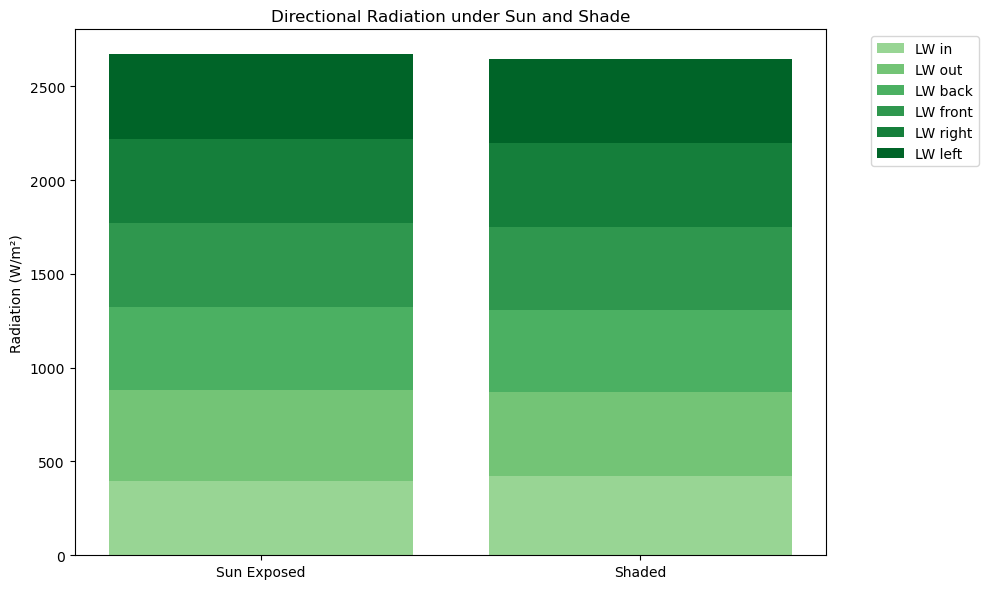

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# 1. Filter based on tree_shade
shade_threshold = 0.9
sun_threshold = 0.1

df_shaded = df_shade_MRT_airtemp_aug[df_shade_MRT_airtemp_aug['tree_2_before_shadow_fraction'] > shade_threshold]
df_sun = df_shade_MRT_airtemp_aug[df_shade_MRT_airtemp_aug['tree_2_before_shadow_fraction'] < sun_threshold]

print(f"number of shaded: {len(df_shaded)}, number of exposed:{len(df_sun)}")

# 2. Define directional columns
sw_cols = ['E_short_in', 'E_short_out', 'E_short_back', 'E_short_front', 'E_short_right', 'E_short_left']
lw_cols = ['E_long_in', 'E_long_out', 'E_long_back', 'E_long_front', 'E_long_right', 'E_long_left']

# 3. Compute mean values
shaded_means = df_shaded[sw_cols + lw_cols].mean()
sun_means = df_sun[sw_cols + lw_cols].mean()

# 4. Create stacked bar data
labels = ['Sun Exposed', 'Shaded']
shortwave_stack = [sun_means[sw_cols].values, shaded_means[sw_cols].values]
longwave_stack = [sun_means[lw_cols].values, shaded_means[lw_cols].values]

# 5. Generate color gradients
sw_colors = plt.cm.Reds(np.linspace(0.4, 0.9, len(sw_cols)))    # From soft to deep red
lw_colors = plt.cm.Greens(np.linspace(0.4, 0.9, len(lw_cols)))  # From soft to deep green

# 5. Plot
fig, ax = plt.subplots(figsize=(10, 6))

bottom = [0, 0]
# Longwave (Green tones)
for i, dir in enumerate(lw_cols):
    values = [longwave_stack[0][i], longwave_stack[1][i]]
    ax.bar(labels, values, bottom=bottom, label=f'LW {dir.split("_")[2]}', color=lw_colors[i])
    bottom = [bottom[j] + values[j] for j in range(2)]

# Shortwave (Red tones)
# for i, dir in enumerate(sw_cols):
#     values = [shortwave_stack[0][i], shortwave_stack[1][i]]
#     ax.bar(labels, values, bottom=bottom, label=f'SW {dir.split("_")[2]}', color=sw_colors[i])
#     bottom = [bottom[j] + values[j] for j in range(2)]

# 6. Aesthetics
ax.set_ylabel('Radiation (W/m²)')
ax.set_title('Directional Radiation under Sun and Shade')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

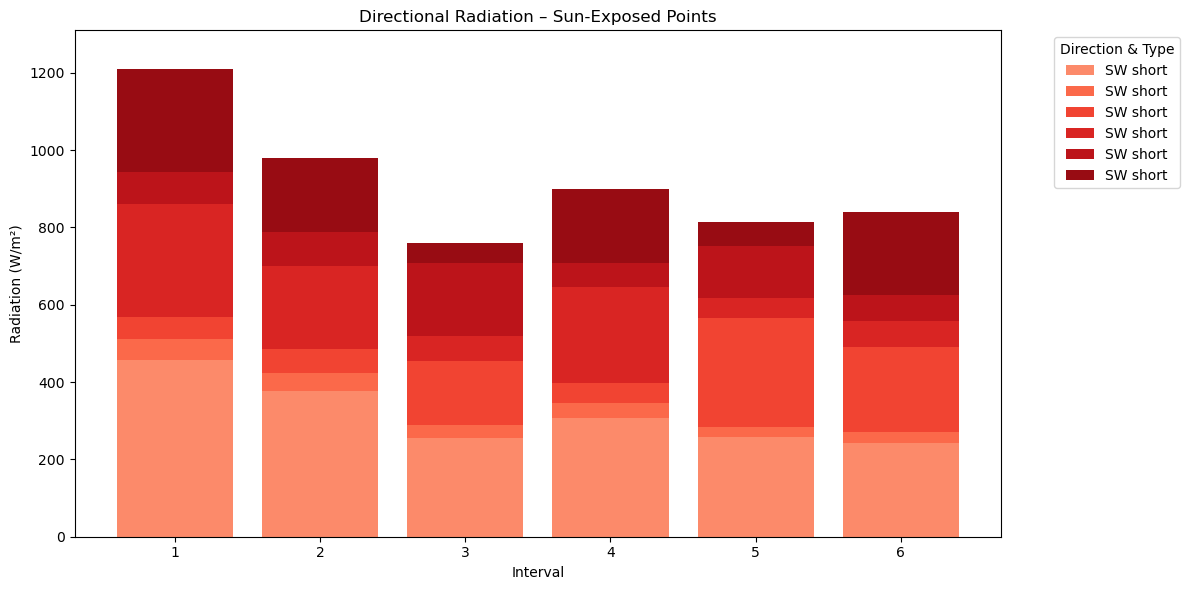

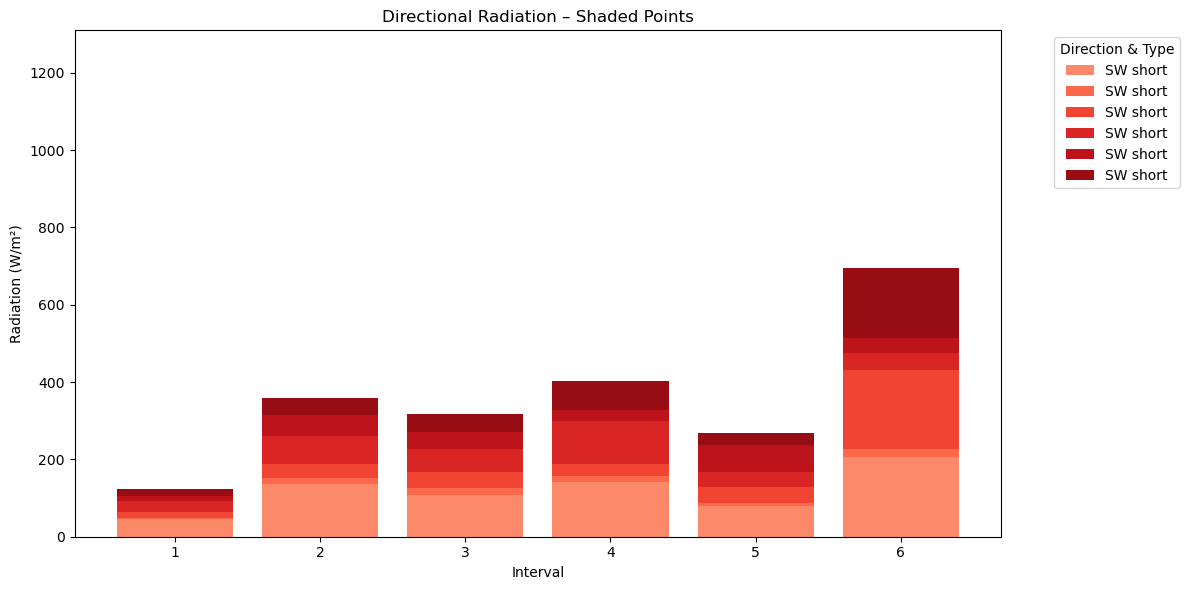

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Convert string time intervals to datetime
august_intervals = [
    ('2023-08-23 13:56:00', '2023-08-23 14:30:00'),
    ('2023-08-23 14:30:00', '2023-08-23 15:00:00'),
    ('2023-08-23 15:00:00', '2023-08-23 15:30:00'),
    ('2023-08-23 15:30:00', '2023-08-23 16:00:00'),
    ('2023-08-23 16:30:00', '2023-08-23 17:00:00'),
    ('2023-08-23 17:00:00', '2023-08-23 17:30:00')
]
august_intervals = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in august_intervals]

# Filter by tree_shade
df_shaded = df_shade_MRT_airtemp_aug[df_shade_MRT_airtemp_aug['tree_shade'] > 0.89]
df_sun = df_shade_MRT_airtemp_aug[df_shade_MRT_airtemp_aug['tree_shade'] < 0.1]

# 2. Define directional columns
sw_cols = ['E_short_in', 'E_short_out', 'E_short_back', 'E_short_front', 'E_short_right', 'E_short_left']
lw_cols = ['E_long_in', 'E_long_out', 'E_long_back', 'E_long_front', 'E_long_right', 'E_long_left']

# Create color gradients
sw_colors = plt.cm.Reds(np.linspace(0.4, 0.9, len(sw_cols)))
lw_colors = plt.cm.Greens(np.linspace(0.4, 0.9, len(lw_cols)))

# Helper to compute means per interval
def compute_interval_means(df, intervals, columns):
    interval_means = []
    for start, end in intervals:
        df_interval = df[(df['TIMESTAMP'] >= start) & (df['TIMESTAMP'] < end)]
        mean_vals = df_interval[columns].mean()
        interval_means.append(mean_vals)
    return interval_means

# Compute per-interval means
shaded_means = compute_interval_means(df_shaded, august_intervals, sw_cols)
sun_means = compute_interval_means(df_sun, august_intervals, sw_cols)

max_radiation = max([s.sum() for s in sun_means]) + 100

def plot_stacked_bars(means_list, title, max_ylim):
    labels = [f'{i+1}' for i in range(len(means_list))]
    fig, ax = plt.subplots(figsize=(12, 6))

    bottom = np.zeros(len(means_list))

    # Shortwave bars
    for i, col in enumerate(sw_cols):
        values = [mean[col] for mean in means_list]
        ax.bar(labels, values, bottom=bottom, label=f'SW {col.split("_")[1]}', color=sw_colors[i])
        bottom += values

    # # Longwave bars
    # for i, col in enumerate(lw_cols):
    #     values = [mean[col] for mean in means_list]
    #     ax.bar(labels, values, bottom=bottom, label=f'LW {col.split("_")[1]}', color=lw_colors[i])
    #     bottom += values

    ax.set_ylabel('Radiation (W/m²)')
    ax.set_title(title)
    ax.set_xlabel('Interval')
    ax.set_ylim(0, max_ylim)  # Set consistent y-axis
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Direction & Type')
    plt.tight_layout()
    plt.show()


plot_stacked_bars(sun_means, 'Directional Radiation – Sun-Exposed Points', max_radiation)
plot_stacked_bars(shaded_means, 'Directional Radiation – Shaded Points', max_radiation)

In [1]:
import pandas as pd
import geopandas as gpd
sun_sensor = pd.read_csv("../data/validation/3k_CY1_Mar_7_2025_3_30_40_PM.csv")
shade_sensor = pd.read_csv("../data/validation/6k_CY1_Mar_7_2025_2_45_00_PM.csv")

### Climatebike Filtering

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your points and routes
points_gdf = gpd.read_file("../data/clean_data/additional/e6a08fb8/climatebike_data_cleaned2.shp")  # Your input points
routes_gdf = gpd.read_file("../data/clean_data/additional/e6a08fb8/estimated_bike_routes2.shp")  # Multiple linestring routes

# # Ensure the same projected CRS (for accurate distance calculations)
# crs = "EPSG:3857"  # Use meters for distance computations
# points_gdf = points_gdf.to_crs(crs)
# routes_gdf = routes_gdf.to_crs(crs)

# # Perform a spatial join to find the nearest route for each point
# nearest_gdf = gpd.sjoin_nearest(points_gdf, routes_gdf, how="left")

# # Convert back to original CRS
# nearest_gdf = nearest_gdf.to_crs("EPSG:4326")

In [2]:
import geopandas as gpd
from shapely.ops import nearest_points
from shapely.geometry import LineString
# import sympy and Point, Line
from sympy import Point, Line

# Ensure both datasets use a projected CRS (for accurate distance calculations)
crs = "EPSG:3857"  # Meters-based CRS for precise distance calculations
points_gdf = points_gdf.to_crs(crs)
routes_gdf = routes_gdf.to_crs(crs)

# Function to get the nearest point on a route
def get_nearest_point_on_route(point, route_gdf):
    # Find the closest route segment
    nearest_route = route_gdf.geometry.iloc[route_gdf.distance(point).idxmin()]

    # Ensure valid geometry
    if nearest_route.is_empty:
        return None, float('inf')

    # Compute the nearest point along the line
    nearest_dist = nearest_route.distance(point)

    return nearest_dist

# Compute nearest points & distances
points_gdf["deviance"] = points_gdf.geometry.apply(lambda x: get_nearest_point_on_route(x, routes_gdf))


In [3]:
points_gdf.columns

Index(['TIMESTAMP', 'RECORD', 'GPSData', 'Air_Temp', 'humidity', 'Qs_in',
       'Qs_out', 'Qs_left', 'Qs_right', 'Qs_front', 'Qs_back', 'QL_in',
       'QL_out', 'QL_left', 'QL_right', 'QL_front', 'QL_back', 'TL_inout',
       'TL_leftrig', 'TL_front', 'TL_back', 'wheelfreq', 'WindDir', 'WS_ms',
       'WSDiag', 'PTemp', 'batt_volt', 'GPSData_ti', 'latitude', 'longitude',
       'geometry', 'deviance'],
      dtype='object')

In [20]:
points_with_timestamp = pd.read_csv("../data/gertjandatafiets_with_MRT.csv")
points_with_timestamp.columns

Index(['TIMESTAMP', 'RECORD', 'GPSData', 'Air_Temp', 'humidity', 'Qs_in',
       'Qs_out', 'Qs_left', 'Qs_right', 'Qs_front', 'Qs_back', 'QL_in',
       'QL_out', 'QL_left', 'QL_right', 'QL_front', 'QL_back', 'TL_inout',
       'TL_leftright', 'TL_front', 'TL_back', 'wheelfreq', 'WindDir', 'WS_ms',
       'WSDiag', 'PTemp', 'batt_volt', 'GPSData_time', 'latitude', 'longitude',
       'T_sensor_K', 'L_corr_term', 'E_in', 'E_out', 'E_left', 'E_right',
       'E_front', 'E_back', 'E_avg', 'MRT_K', 'MRT_C', 'E_long_in',
       'E_short_in', 'E_total_in', 'E_long_out', 'E_short_out', 'E_total_out',
       'E_long_left', 'E_short_left', 'E_total_left', 'E_long_right',
       'E_short_right', 'E_total_right', 'E_long_front', 'E_short_front',
       'E_total_front', 'E_long_back', 'E_short_back', 'E_total_back'],
      dtype='object')

In [ ]:
points_gdf

TODO: ISSUE Why are all the points same distance from the line, check visually as well

Solved: There are many points that are duplicate on the exact same spot but have different radiatione etc. values

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=points_gdf["deviance"].unique(), color="steelblue")
plt.xlabel("Deviance from Route (meters)")
plt.title("Deviance from Route")
plt.show()

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(range(len(points_gdf)), points_gdf["deviance"], color="steelblue", alpha=0.6)
plt.axhline(points_gdf["deviance"].unique().mean(), color="red", linestyle="dashed", label="Mean Deviance")
plt.xlabel("Point Index")
plt.ylabel("Deviance from Route (meters)")
plt.title("Scatter Plot of Deviance from Route")
plt.legend()
plt.show()

In [8]:
import numpy as np

q3 = np.quantile(points_gdf["deviance"].unique(), 0.75)
print("75th Percentile (Q3) Deviance:", q3)

75th Percentile (Q3) Deviance: 7.273932154687051


In [9]:
filtered_gdf = points_gdf[points_gdf["deviance"] <= q3]
filtered_gdf

,TIMESTAMP,RECORD,GPSData,Air_Temp,humidity,Qs_in,Qs_out,Qs_left,Qs_right,Qs_front,...,WindDir,WS_ms,WSDiag,PTemp,batt_volt,GPSData_ti,latitude,longitude,geometry,deviance
0,2023-08-23,56706,230823115735N5222666E00452996G004-00018E0000N0...,25.33,48.43,38.70,2.243,14.950,8.24,19.76,...,179,1.32,0,26.07,12.52,2.310000e+11,52.377767,4.883267,POINT Z (543602.759 6868720.859 0),2.101566
1,2023-08-23,56707,230823115736N5222666E00452996G004-00018E0000N0...,25.29,48.43,38.70,2.243,15.170,8.24,19.76,...,162,1.55,0,26.07,12.42,2.310000e+11,52.377767,4.883267,POINT Z (543602.759 6868720.859 0),2.101566
2,2023-08-23,56708,230823115737N5222666E00452996G004-00018E0000N0...,25.29,48.46,38.70,2.243,15.170,8.24,19.76,...,161,1.12,0,26.07,12.52,2.310000e+11,52.377767,4.883267,POINT Z (543602.759 6868720.859 0),2.101566
3,2023-08-23,56709,230823115738N5222666E00452996G004-00018E0000N0...,25.22,48.45,38.92,2.243,15.170,8.24,19.76,...,170,1.01,0,26.07,12.48,2.310000e+11,52.377767,4.883267,POINT Z (543602.759 6868720.859 0),2.101566
4,2023-08-23,56710,230823115739N5222666E00452996G004-00018E0000N0...,25.13,48.38,38.92,2.243,15.170,8.24,19.76,...,169,1.98,0,26.07,12.52,2.310000e+11,52.377767,4.883267,POINT Z (543602.759 6868720.859 0),2.101566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26863,2023-09-12,90934,230912143818N5222514E00454853G004+00013E0002S0...,21.19,86.50,47.42,-0.224,5.275,25.78,22.61,...,357,2.51,0,25.52,12.58,2.310000e+11,52.375233,4.914217,POINT Z (547048.097 6868258.903 0),1.076952
26864,2023-09-12,90935,230912143819N5222513E00454853G004+00012E0001S0...,21.19,86.50,49.97,0.000,5.715,28.10,22.61,...,0,2.20,0,25.52,12.46,2.310000e+11,52.375217,4.914217,POINT Z (547048.097 6868255.865 0),0.167454
26865,2023-09-12,90936,230912143820N5222511E00454853G004+00012E0009S0...,21.19,86.50,50.82,0.224,6.154,29.58,22.61,...,3,1.48,0,25.55,12.35,2.310000e+11,52.375183,4.914217,POINT Z (547048.097 6868249.786 0),2.292221
26866,2023-09-12,90937,230912143821N5222510E00454854G004+00012E0011S0...,21.17,86.50,51.04,0.224,6.594,30.21,22.61,...,17,0.16,0,25.52,12.35,2.310000e+11,52.375167,4.914233,POINT Z (547049.952 6868246.748 0),4.783043


In [10]:
from shapely.ops import nearest_points

# Function to find the closest point on a route for a given point
def map_to_nearest_route(point, route_gdf):
    nearest_geom = route_gdf.geometry.iloc[route_gdf.distance(point).idxmin()]
    return nearest_points(point, nearest_geom)[1]  # Get the closest point on the route

# Apply function to each point
filtered_gdf["mapped_point"] = filtered_gdf["geometry"].apply(lambda x: map_to_nearest_route(x, routes_gdf))

c:\Users\Dila Ozberkman\miniconda3\envs\shade_env\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [11]:
filtered_gdf_mapped = filtered_gdf.drop(["geometry", "deviance", "longitude", "latitude"], axis=1)

In [14]:
filtered_gdf_mapped = gpd.GeoDataFrame(filtered_gdf_mapped, geometry=filtered_gdf["mapped_point"])

In [15]:
filtered_gdf_mapped = filtered_gdf_mapped.drop(["mapped_point"], axis=1)

In [18]:
filtered_gdf_mapped = filtered_gdf_mapped.drop(['TIMESTAMP'], axis=1)

In [ ]:
filtered_gdf_mapped = filtered_gdf_mapped.to_crs("EPSG:32631")

In [21]:
filtered_gdf_mapped = pd.merge(filtered_gdf_mapped, points_with_timestamp[['RECORD', 'TIMESTAMP','T_sensor_K', 'L_corr_term', 'E_in', 'E_out', 'E_left', 'E_right',
       'E_front', 'E_back', 'E_avg', 'MRT_K', 'MRT_C', 'E_long_in',
       'E_short_in', 'E_total_in', 'E_long_out', 'E_short_out', 'E_total_out',
       'E_long_left', 'E_short_left', 'E_total_left', 'E_long_right',
       'E_short_right', 'E_total_right', 'E_long_front', 'E_short_front',
       'E_total_front', 'E_long_back', 'E_short_back', 'E_total_back']], on='RECORD', how='left')

In [30]:
filtered_gdf_mapped.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [31]:
filtered_gdf = filtered_gdf_mapped.to_crs("EPSG:32631")

In [ ]:
# # Convert back to WGS84 for mapping
# filtered_gdf = filtered_gdf.to_crs("EPSG:4326")

# Create a new GeoDataFrame with mapped points
mapped_gdf = gpd.GeoDataFrame(geometry=filtered_gdf_mapped)


In [32]:
x = filtered_gdf.to_file("../data/clean_data/additional/e6a08fb8/filtered_mapped_climatebike_2.geojson", driver="GEOJSON")

In [ ]:
# Plot the data
fig, ax = plt.subplots(figsize=(10, 8))

filtered_gdf = filtered_gdf.to_crs("EPSG:3857")
mapped_gdf = mapped_gdf.to_crs("EPSG:3857")
routes_gdf = routes_gdf.to_crs("EPSG:3857")

# Plot mapped points
mapped_gdf.plot(ax=ax, color="green", markersize=10, alpha=0.7, label="Mapped Points")

# # Plot routes
routes_gdf.plot(ax=ax, color="blue", linewidth=2, label="Routes")

# # Plot original points
filtered_gdf.plot(ax=ax, color="red", markersize=10, alpha=0.7, label="Original Points")

# Add labels and legend
plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Original vs Mapped Points on Routes")

# Show the plot
plt.show()

## Sensor Data

#### Clean data

In [2]:
sun_sensor.columns

Index(['FORMATTED DATE_TIME', 'Temperature', 'Wet Bulb Temp',
       'Globe Temperature', 'Relative Humidity', 'Barometric Pressure',
       'Altitude', 'Station Pressure', 'Wind Speed', 'Heat Index', 'Dew Point',
       'Density Altitude', 'Crosswind', 'Headwind',
       'Compass Magnetic Direction', 'NWB Temp', 'Compass True Direction',
       'Thermal Work Limit', 'Wet Bulb Globe Temperature', 'Wind Chill',
       'Data Type', 'Record name', 'Start time', 'Duration (H:M:S)',
       'Location description', 'Location address', 'Location coordinates',
       'Notes'],
      dtype='object')

In [3]:
sun_sensor = sun_sensor.drop(['Location description','Location address','Location coordinates','Notes'], axis=1)
shade_sensor = shade_sensor.drop(['Location description','Location address','Location coordinates','Notes'], axis=1)

In [4]:
sun_sensor = sun_sensor.iloc[1:]
shade_sensor = shade_sensor.iloc[1:]

In [5]:
for col in ['Temperature', 'Wet Bulb Temp', 'Globe Temperature', 'Relative Humidity','Wind Speed', 'Heat Index']:
    # Convert Globe Temperature to float
    sun_sensor[col] = pd.to_numeric(sun_sensor[col], errors='coerce')
    shade_sensor[col] = pd.to_numeric(shade_sensor[col], errors='coerce')

In [6]:
sun_sensor['FORMATTED DATE_TIME'] = pd.to_datetime(sun_sensor['FORMATTED DATE_TIME'])
shade_sensor['FORMATTED DATE_TIME'] = pd.to_datetime(shade_sensor['FORMATTED DATE_TIME'])

In [8]:
sun_sensor

,FORMATTED DATE_TIME,Temperature,Wet Bulb Temp,Globe Temperature,Relative Humidity,Barometric Pressure,Altitude,Station Pressure,Wind Speed,Heat Index,...,Compass Magnetic Direction,NWB Temp,Compass True Direction,Thermal Work Limit,Wet Bulb Globe Temperature,Wind Chill,Data Type,Record name,Start time,Duration (H:M:S)
1,2024-08-27 08:24:00,22.4,17.1,22.1,58.5,1023.7,-89,1023.8,0.0,22.3,...,--,17.6,--,242,19,22.4,point,NaN,NaN,NaN
2,2024-08-27 08:24:00,22.4,17.1,22.1,58.7,1023.5,-86,1023.5,0.0,22.3,...,--,17.6,--,242,19,22.4,point,NaN,NaN,NaN
3,2024-08-27 08:24:00,22.4,17.1,22.1,58.8,1023.5,-86,1023.5,0.0,22.3,...,--,17.6,--,242,19,22.4,point,NaN,NaN,NaN
4,2024-08-27 08:24:00,22.4,17.1,22.1,58.9,1024.6,-97,1024.7,0.0,22.3,...,--,17.6,--,242,19,22.4,point,NaN,NaN,NaN
5,2024-08-27 08:24:00,22.5,17.2,22.1,59.0,1023.4,-86,1023.4,0.0,22.3,...,--,17.6,--,242,19,22.4,point,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10545,2025-03-07 12:19:00,16.2,10.7,27.2,50.5,1018.7,-47,1018.7,8.7,14.6,...,--,13.5,--,320,16.5,15.8,session,"Session - Mar 7, 2025 11:57:47 AM",2025-03-07 11:57:47 AM 11:57:47 AM,0:22:30
10546,2025-03-07 12:20:00,15.4,10.0,16.5,50.4,1018.2,-44,1018.3,10.0,13.8,...,--,10.1,--,320,11.8,14.7,session,"Session - Mar 7, 2025 11:57:47 AM",2025-03-07 11:57:47 AM 11:57:47 AM,0:22:30
10547,2025-03-07 12:20:00,16.2,10.7,27.3,50.6,1018.5,-46,1018.6,8.8,14.6,...,--,13.5,--,320,16.5,15.8,session,"Session - Mar 7, 2025 11:57:47 AM",2025-03-07 11:57:47 AM 11:57:47 AM,0:22:30
10548,2025-03-07 12:20:00,16.2,10.8,27.4,50.8,1018.5,-47,1018.6,7.6,14.6,...,--,13.5,--,320,16.5,15.9,session,"Session - Mar 7, 2025 11:57:47 AM",2025-03-07 11:57:47 AM 11:57:47 AM,0:22:30


#### Filter to the right timeframe

In [ ]:
sun_sensor_0307 = sun_sensor[sun_sensor['FORMATTED DATE_TIME'].dt.month == 3]
shade_sensor_0307 = shade_sensor[shade_sensor['FORMATTED DATE_TIME'].dt.month == 3]

In [ ]:
sun_max = max(sun_sensor_0307['FORMATTED DATE_TIME'])
sun_min = min(sun_sensor_0307['FORMATTED DATE_TIME'])
shade_max = max(shade_sensor_0307['FORMATTED DATE_TIME'])
shade_min = min(shade_sensor_0307['FORMATTED DATE_TIME'])
print(f"Sun data range {sun_min} - {sun_max}")
print(f"Shade data range {shade_min} - {shade_max}")

In [ ]:
sun_data_range = sun_sensor_0307[(sun_sensor_0307['FORMATTED DATE_TIME'] >= pd.to_datetime('2025-03-07 14:10:00')) &
                            (sun_sensor_0307['FORMATTED DATE_TIME'] <= pd.to_datetime('2025-03-07 14:40:00'))]

shade_data_range = shade_sensor_0307[(shade_sensor_0307['FORMATTED DATE_TIME'] >= pd.to_datetime('2025-03-07 14:10:00')) &
                            (shade_sensor_0307['FORMATTED DATE_TIME'] <= pd.to_datetime('2025-03-07 14:40:00'))]

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Extract time and Globe Temperature values
sun_time = sun_data_range['FORMATTED DATE_TIME']
sun_temp = sun_data_range['Wet Bulb Temp']

shade_time = shade_data_range['FORMATTED DATE_TIME']
shade_temp = shade_data_range['Wet Bulb Temp']

# Plot
plt.figure(figsize=(8, 5))

# Scatter plot for actual data points
plt.scatter(sun_time, sun_temp, color='red', label='Sun Sensor (Points)', alpha=0.6)
plt.scatter(shade_time, shade_temp, color='blue', label='Shade Sensor (Points)', alpha=0.6)

# Formatting
plt.xlabel("Time")
plt.ylabel("Wet Bulb Temp (°C)")
plt.title("Wet Bulb Temp vs Time")
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [ ]:
sun_sensor.head(5)

In [ ]:
sun_sensor['Record name']

In [ ]:
shade_sensor['Globe Temperature'].values